<img src='https://user-images.githubusercontent.com/73154316/136381087-867ba3ac-b403-4ae5-b942-ae30d5c02f41.png' />

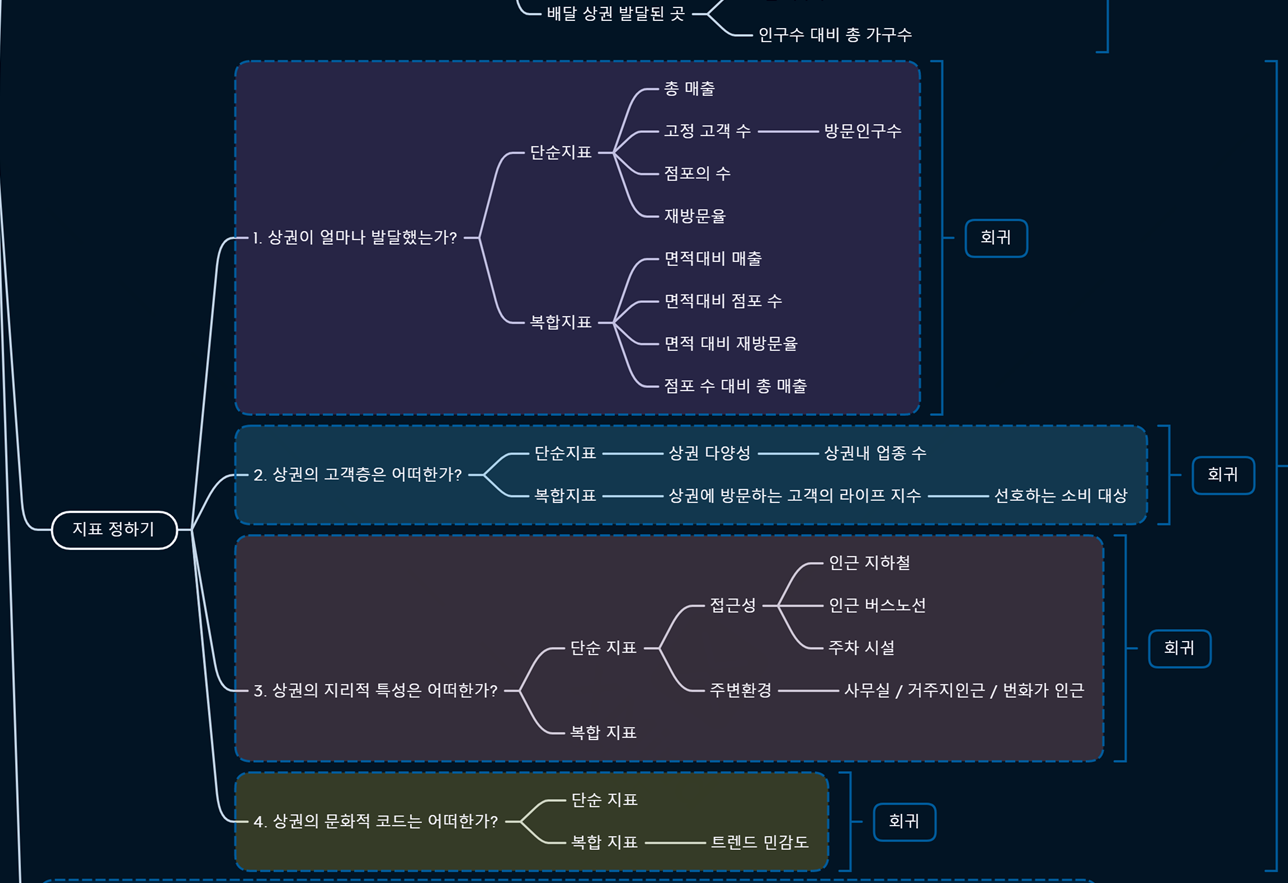

# 기본 로드

###### 라이브러리 로드

In [1]:
# 기초 전처리
import pandas as pd
import numpy as np
import geopandas as gpd
from tqdm import tqdm
%matplotlib inline

# 시각화
import matplotlib.pyplot as plt
import seaborn as sns
import folium
import os

# 캔버스 사이즈 적용
plt.rcParams['figure.figsize'] = (12, 9)

# 컬럼 전체 확인 가능하도록 출력 범위 설정
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 10000)

# 불필요한 경고 표시 생략
import warnings
warnings.filterwarnings(action = 'ignore')

###### 필요 함수 로드

In [2]:
def get_object_type(df):
    df['상권_코드'] = df['상권_코드'].apply(lambda x : str(x))
    df.astype({'상권_코드':object})
    try:
        df.drop('상권_이름', inplace=True, axis=1)
    except:
        pass
    return df

In [3]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
def get_Standard(df_x):
    s_scaler = StandardScaler()
    return s_scaler.fit_transform(np.array(df_x).reshape(-1, 1))

def get_MinMaxScaler(df_x):
    m_scaler = MinMaxScaler()
    return m_scaler.fit_transform(np.array(df_x).reshape(-1, 1))

In [4]:
# 피밸류 보는 함수
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from scipy import stats
def get_summary(X,y):
    X2 = sm.add_constant(X)
    est = sm.OLS(y, X2)
    est2 = est.fit()
    print(est2.summary())

In [67]:
import seaborn as sns
import matplotlib.pyplot as plt

def get_VIF(df):
    plt.rcParams['font.family'] = 'Malgun Gothic'
    # cmap = sns.light_palette("darkgray", as_cmap=True)
    cmap = sns.diverging_palette(230, 20, as_cmap=True)
    sns.heatmap(df.corr(), annot=True, cmap=cmap)
    plt.show()

###### 자료 로드

**훈련 데이터 list**

* 상권건물.csv

* 상권건물_배후지.csv

* 상권인구.csv

* 상권인구_배후지.csv

* 상권점포.csv

* 상권점포_배후지.csv

* 매출 분석 !! 준혁



* 지리 자료 !! 승순


**타겟 데이터 list**

* 경향성 분석 !! 
    * j_result/매출_회귀계수.csv
    * j_result/음식_회귀계수.csv
    * j_result/주말_회귀계수.csv

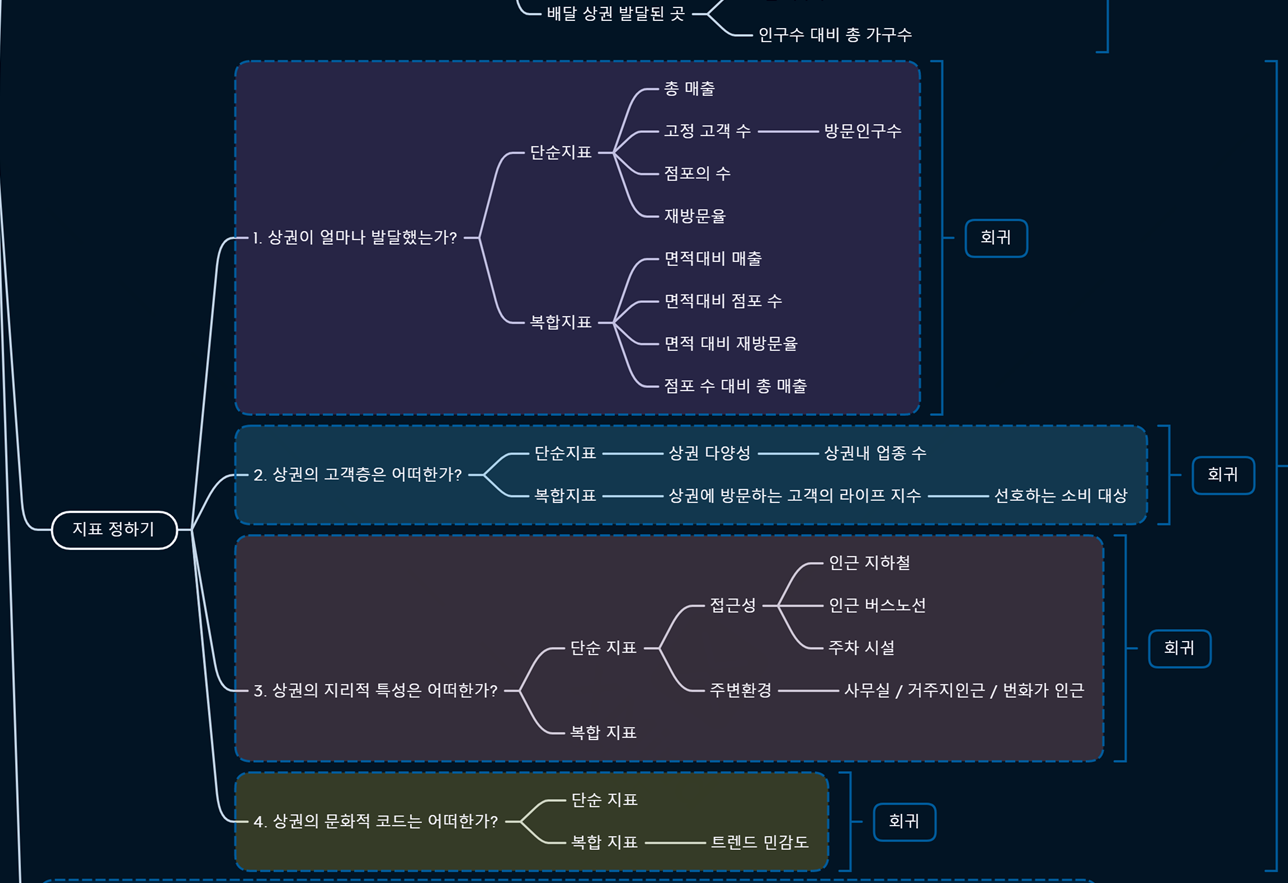

# Summary - 상권이 얼마나 발달했는가?

###### 단순지표

1. 총매출

2. 고객수를 대표 할 지수

3. 점포의 수

5. 유동인구



######  복합지표

1. 재방문율? 고정 방문 고객수? 

1. 면적대비 매출

2. 점포수 대비 매출

3. 면전 대비 점포수

###### 영향력 평가

1. 다중공성선 평가 : VIF

2. Feature Selection : Stepwise, 



# 단순지표

###### 단순지표

1. 총매출

2. 고객수를 대표 할 지수

3. 점포의 수

5. 유동인구



###### base 생성

In [6]:
bs_area = gpd.read_file('data/geojson/상권_geometry_좌표.geojson', driver= 'GeoJSON')
bs_area= bs_area[bs_area['TRDAR_SE_C'] == 'A']
df_base = bs_area[['TRDAR_CD','TRDAR_SE_1']].sort_values('TRDAR_CD').reset_index(drop=True)
df_base.columns = ['상권_코드', '상권_이름']
df_base = get_object_type(df_base)
df_base.head()

,상권_코드
0,1000001
1,1000002
2,1000003
3,1000004
4,1000005


In [7]:
df_all = df_base.copy()

##  총매출

`1년_매출`, `1년_매출_log`

In [8]:
# 20_34, 21_12 분기 매출
df_rev = pd.read_csv('data/my_result/1년_매출.csv')
df_rev['1년_매출_log'] = df_rev['1년_매출'].agg(np.log1p)
df_rev = get_object_type(df_rev)

In [9]:
df_rev

,상권_코드,1년_매출,1년_매출_log
0,1000001,1.512657e+10,23.439719
1,1000002,1.599466e+10,23.495521
2,1000003,2.874329e+10,24.081670
3,1000004,1.072206e+10,23.095569
4,1000005,1.043475e+10,23.068407
...,...,...,...
1475,1001486,7.502853e+09,22.738549
1476,1001487,1.325915e+10,23.307954
1477,1001488,1.784020e+10,23.604720
1478,1001489,6.838972e+10,24.948488


In [10]:
df_rev.isnull().sum()

상권_코드        0
1년_매출        0
1년_매출_log    0
dtype: int64

In [11]:
df_all = pd.merge(left=df_all, right=df_rev, on='상권_코드', how='left')
# df_all

In [12]:
df_all.isnull().sum()

상권_코드        0
1년_매출        1
1년_매출_log    1
dtype: int64

## 고객수를 대표 할 지수?!

`배후지_총_생활_인구_수`

In [13]:
df_pop_b = pd.read_csv('data/my_result/상권인구_배후지.csv')
df_pop_b = get_object_type(df_pop_b)

In [14]:
df_pop_b

,상권_코드,배후지_총_생활인구_수,배후지_남성_생활인구_수,배후지_여성_생활인구_수,배후지_연령대_10_생활인구_수,배후지_연령대_20_생활인구_수,배후지_연령대_30_생활인구_수,배후지_연령대_40_생활인구_수,배후지_연령대_50_생활인구_수,배후지_연령대_60_이상_생활인구_수,배후지_시간대_1_생활인구_수,배후지_시간대_2_생활인구_수,배후지_시간대_3_생활인구_수,배후지_시간대_4_생활인구_수,배후지_시간대_5_생활인구_수,배후지_시간대_6_생활인구_수,배후지_월요일_생활인구_수,배후지_화요일_생활인구_수,배후지_수요일_생활인구_수,배후지_목요일_생활인구_수,배후지_금요일_생활인구_수,배후지_토요일_생활인구_수,배후지_일요일_생활인구_수,배후지_남성_생활인구_수_총인구대비_비율,배후지_여성_생활인구_수_총인구대비_비율,배후지_연령대_10_생활인구_수_총인구대비_비율,배후지_연령대_20_생활인구_수_총인구대비_비율,배후지_연령대_30_생활인구_수_총인구대비_비율,배후지_연령대_40_생활인구_수_총인구대비_비율,배후지_연령대_50_생활인구_수_총인구대비_비율,배후지_연령대_60_이상_생활인구_수_총인구대비_비율,배후지_시간대_1_생활인구_수_총인구대비_비율,배후지_시간대_2_생활인구_수_총인구대비_비율,배후지_시간대_3_생활인구_수_총인구대비_비율,배후지_시간대_4_생활인구_수_총인구대비_비율,배후지_시간대_5_생활인구_수_총인구대비_비율,배후지_시간대_6_생활인구_수_총인구대비_비율,배후지_월요일_생활인구_수_총인구대비_비율,배후지_화요일_생활인구_수_총인구대비_비율,배후지_수요일_생활인구_수_총인구대비_비율,배후지_목요일_생활인구_수_총인구대비_비율,배후지_금요일_생활인구_수_총인구대비_비율,배후지_토요일_생활인구_수_총인구대비_비율,배후지_일요일_생활인구_수_총인구대비_비율
0,1000001,1081142.00,548255.25,532886.50,134831.50,153452.75,207655.50,217873.00,166640.00,200689.00,196188.25,241729.50,184454.0,182949.75,175165.75,100654.00,162101.00,167880.75,165795.50,165458.25,161774.00,132598.50,125534.25,0.507108,0.492892,0.124712,0.141936,0.192071,0.201521,0.154133,0.185627,0.181464,0.223587,0.170610,0.169219,0.162019,0.093100,0.149935,0.155281,0.153352,0.153040,0.149633,0.122647,0.116113
1,1000002,3643150.75,1825662.75,1817487.75,284956.00,598842.00,694745.50,623937.75,605031.25,835639.75,746978.50,764628.75,561650.0,563432.00,612312.00,394149.50,525121.75,528357.00,528595.75,526032.00,522033.00,506913.50,506097.75,0.501122,0.498878,0.078217,0.164375,0.190699,0.171263,0.166074,0.229373,0.205036,0.209881,0.154166,0.154655,0.168072,0.108189,0.144139,0.145027,0.145093,0.144389,0.143292,0.139142,0.138918
2,1000003,1732769.00,991745.25,741023.75,86649.00,322533.00,324534.75,319177.00,283800.25,396075.50,226121.25,336842.75,327960.0,345895.50,352877.50,143073.00,259865.00,271250.50,269837.50,268060.50,264725.25,218046.25,180985.00,0.572347,0.427653,0.050006,0.186137,0.187293,0.184201,0.163784,0.228580,0.130497,0.194396,0.189269,0.199620,0.203649,0.082569,0.149971,0.156542,0.155726,0.154701,0.152776,0.125837,0.104448
3,1000004,3164952.75,1481436.75,1683515.75,540905.75,948747.75,344886.75,412236.00,347404.25,570772.25,972296.25,689002.00,347553.5,317651.50,431292.25,407156.25,455354.50,457978.50,455669.75,455144.50,445046.00,441920.00,453840.75,0.468075,0.531924,0.170905,0.299767,0.108971,0.130250,0.109766,0.180341,0.307207,0.217697,0.109813,0.100365,0.136271,0.128645,0.143874,0.144703,0.143974,0.143808,0.140617,0.139629,0.143396
4,1000005,460215.00,216288.00,243927.75,67459.50,53214.75,54157.75,81447.75,78065.50,125869.50,124005.50,100354.25,54898.5,52622.50,69417.25,58917.00,64428.00,65039.00,65516.75,64755.75,65270.00,67085.00,68120.50,0.469972,0.530030,0.146583,0.115630,0.117679,0.176978,0.169628,0.273502,0.269451,0.218059,0.119289,0.114343,0.150837,0.128021,0.139995,0.141323,0.142361,0.140708,0.141825,0.145769,0.148019
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1485,1001486,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1486,1001487,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1487,1001488,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1488,1001489,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [15]:
df_pop_b_selected = df_pop_b.loc[:,:'배후지_일요일_생활인구_수']
df_pop_b_selected

,상권_코드,배후지_총_생활인구_수,배후지_남성_생활인구_수,배후지_여성_생활인구_수,배후지_연령대_10_생활인구_수,배후지_연령대_20_생활인구_수,배후지_연령대_30_생활인구_수,배후지_연령대_40_생활인구_수,배후지_연령대_50_생활인구_수,배후지_연령대_60_이상_생활인구_수,배후지_시간대_1_생활인구_수,배후지_시간대_2_생활인구_수,배후지_시간대_3_생활인구_수,배후지_시간대_4_생활인구_수,배후지_시간대_5_생활인구_수,배후지_시간대_6_생활인구_수,배후지_월요일_생활인구_수,배후지_화요일_생활인구_수,배후지_수요일_생활인구_수,배후지_목요일_생활인구_수,배후지_금요일_생활인구_수,배후지_토요일_생활인구_수,배후지_일요일_생활인구_수
0,1000001,1081142.00,548255.25,532886.50,134831.50,153452.75,207655.50,217873.00,166640.00,200689.00,196188.25,241729.50,184454.0,182949.75,175165.75,100654.00,162101.00,167880.75,165795.50,165458.25,161774.00,132598.50,125534.25
1,1000002,3643150.75,1825662.75,1817487.75,284956.00,598842.00,694745.50,623937.75,605031.25,835639.75,746978.50,764628.75,561650.0,563432.00,612312.00,394149.50,525121.75,528357.00,528595.75,526032.00,522033.00,506913.50,506097.75
2,1000003,1732769.00,991745.25,741023.75,86649.00,322533.00,324534.75,319177.00,283800.25,396075.50,226121.25,336842.75,327960.0,345895.50,352877.50,143073.00,259865.00,271250.50,269837.50,268060.50,264725.25,218046.25,180985.00
3,1000004,3164952.75,1481436.75,1683515.75,540905.75,948747.75,344886.75,412236.00,347404.25,570772.25,972296.25,689002.00,347553.5,317651.50,431292.25,407156.25,455354.50,457978.50,455669.75,455144.50,445046.00,441920.00,453840.75
4,1000005,460215.00,216288.00,243927.75,67459.50,53214.75,54157.75,81447.75,78065.50,125869.50,124005.50,100354.25,54898.5,52622.50,69417.25,58917.00,64428.00,65039.00,65516.75,64755.75,65270.00,67085.00,68120.50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1485,1001486,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1486,1001487,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1487,1001488,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1488,1001489,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [16]:
df_all = pd.merge(left=df_all, right=df_pop_b_selected, on='상권_코드', how='left')
df_all

,상권_코드,1년_매출,1년_매출_log,배후지_총_생활인구_수,배후지_남성_생활인구_수,배후지_여성_생활인구_수,배후지_연령대_10_생활인구_수,배후지_연령대_20_생활인구_수,배후지_연령대_30_생활인구_수,배후지_연령대_40_생활인구_수,배후지_연령대_50_생활인구_수,배후지_연령대_60_이상_생활인구_수,배후지_시간대_1_생활인구_수,배후지_시간대_2_생활인구_수,배후지_시간대_3_생활인구_수,배후지_시간대_4_생활인구_수,배후지_시간대_5_생활인구_수,배후지_시간대_6_생활인구_수,배후지_월요일_생활인구_수,배후지_화요일_생활인구_수,배후지_수요일_생활인구_수,배후지_목요일_생활인구_수,배후지_금요일_생활인구_수,배후지_토요일_생활인구_수,배후지_일요일_생활인구_수
0,1000001,1.512657e+10,23.439719,1081142.00,548255.25,532886.50,134831.50,153452.75,207655.50,217873.00,166640.00,200689.00,196188.25,241729.50,184454.00,182949.75,175165.75,100654.00,162101.00,167880.75,165795.50,165458.25,161774.00,132598.50,125534.25
1,1000002,1.599466e+10,23.495521,3643150.75,1825662.75,1817487.75,284956.00,598842.00,694745.50,623937.75,605031.25,835639.75,746978.50,764628.75,561650.00,563432.00,612312.00,394149.50,525121.75,528357.00,528595.75,526032.00,522033.00,506913.50,506097.75
2,1000003,2.874329e+10,24.081670,1732769.00,991745.25,741023.75,86649.00,322533.00,324534.75,319177.00,283800.25,396075.50,226121.25,336842.75,327960.00,345895.50,352877.50,143073.00,259865.00,271250.50,269837.50,268060.50,264725.25,218046.25,180985.00
3,1000004,1.072206e+10,23.095569,3164952.75,1481436.75,1683515.75,540905.75,948747.75,344886.75,412236.00,347404.25,570772.25,972296.25,689002.00,347553.50,317651.50,431292.25,407156.25,455354.50,457978.50,455669.75,455144.50,445046.00,441920.00,453840.75
4,1000005,1.043475e+10,23.068407,460215.00,216288.00,243927.75,67459.50,53214.75,54157.75,81447.75,78065.50,125869.50,124005.50,100354.25,54898.50,52622.50,69417.25,58917.00,64428.00,65039.00,65516.75,64755.75,65270.00,67085.00,68120.50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1005,1001006,1.250092e+10,23.249068,5769453.25,2625373.75,3144080.25,1053344.50,639471.50,761018.00,870007.50,916213.25,1529398.75,1541225.75,1167899.50,659891.00,670773.00,968253.75,761410.75,811607.25,805731.75,809624.25,809589.50,810969.50,847046.00,874885.50
1006,1001007,1.723727e+10,23.570340,1411216.75,679818.00,731398.50,208156.00,155367.25,206395.75,233050.00,252466.75,355781.25,374413.50,302230.25,166217.50,160903.50,226372.75,181080.25,203808.25,203769.75,202984.25,202502.00,202081.75,197799.25,198271.50
1007,1001008,2.267043e+10,23.844327,7262764.25,3316362.00,3946403.00,912443.75,1037201.50,1229288.75,1133166.50,1114189.75,1836474.25,1796720.75,1443650.50,884636.25,906106.25,1302851.00,928799.00,1021670.75,1023656.25,1027280.50,1023607.25,1029294.50,1071366.00,1065889.50
1008,1001009,8.707442e+09,22.887444,8715362.50,3971323.00,4744039.25,1283890.75,1133539.50,1421086.00,1367469.75,1318402.50,2190974.75,2255199.25,1774693.50,1039842.50,1039749.00,1485414.75,1120463.00,1236473.00,1235512.25,1238106.75,1235409.25,1235197.75,1262281.00,1272383.75


## 점포의 수

In [17]:
df_store = pd.read_csv('data/my_result/상권점포.csv')
df_store = get_object_type(df_store)

In [18]:
df_store

,상권_코드,점포_수,점포수_기타,점포수_미용/의류,점포수_생활 필수,점포수_여가,점포수_외식,점포수_편의시설,폐업_점포_수,개업_점포_수,프렌차이즈_점포_수
0,1000001,204.00,44.50,32.75,26.50,26.00,52.25,22.00,5.00,6.25,10.75
1,1000002,113.75,36.00,24.25,11.25,7.00,13.75,21.50,2.25,1.00,7.00
2,1000003,284.00,84.25,19.00,28.00,33.50,67.25,52.00,8.75,4.75,13.75
3,1000004,74.25,3.00,3.00,11.50,0.50,50.25,6.00,3.00,2.00,10.50
4,1000005,75.50,14.25,4.00,10.50,7.00,31.00,8.75,1.25,2.25,4.00
...,...,...,...,...,...,...,...,...,...,...,...
1491,1001492,8526.75,718.75,4208.25,981.50,707.75,1270.75,639.75,220.50,101.50,637.00
1492,1001493,12637.75,403.50,11068.25,380.00,115.75,394.25,276.00,329.50,65.75,210.25
1493,1001494,5182.00,1437.25,1709.50,449.75,215.00,845.25,525.25,104.00,68.50,237.75
1494,1001495,2229.50,305.75,744.00,226.75,128.50,529.50,295.00,62.75,50.00,241.50


In [19]:
df_store.describe().T

,count,mean,std,min,25%,50%,75%,max
점포_수,1496.0,229.835561,503.511375,2.0,90.25,139.00,205.0625,12637.75
점포수_기타,1494.0,30.233601,66.570899,0.0,9.75,17.00,29.2500,1437.25
점포수_미용/의류,1493.0,57.299062,333.659362,0.0,13.75,23.25,37.7500,11068.25
점포수_생활 필수,1494.0,35.050703,64.456000,0.0,14.00,22.00,33.7500,1381.00
점포수_여가,1463.0,14.509398,31.181170,0.0,4.00,8.00,15.0000,707.75
점포수_외식,1495.0,53.051672,83.841443,0.0,19.00,33.50,57.2500,1482.50
점포수_편의시설,1489.0,40.438046,79.349576,0.0,13.25,23.00,37.7500,1290.50
폐업_점포_수,1496.0,6.147393,13.437736,0.0,2.00,3.75,6.0000,329.50
개업_점포_수,1496.0,5.377005,7.576957,0.0,2.25,3.75,6.0000,125.50
프렌차이즈_점포_수,1496.0,18.287600,33.406171,0.0,5.00,10.00,17.5000,637.00


In [20]:
df_store_selected = df_store[['상권_코드', '점포_수', '점포수_외식', '점포수_미용/의류']]
df_store_selected

,상권_코드,점포_수,점포수_외식,점포수_미용/의류
0,1000001,204.00,52.25,32.75
1,1000002,113.75,13.75,24.25
2,1000003,284.00,67.25,19.00
3,1000004,74.25,50.25,3.00
4,1000005,75.50,31.00,4.00
...,...,...,...,...
1491,1001492,8526.75,1270.75,4208.25
1492,1001493,12637.75,394.25,11068.25
1493,1001494,5182.00,845.25,1709.50
1494,1001495,2229.50,529.50,744.00


In [21]:
df_store_selected = get_object_type(df_store_selected)
df_all = pd.merge(left=df_all, right=df_store_selected, on='상권_코드', how='left')
df_all

,상권_코드,1년_매출,1년_매출_log,배후지_총_생활인구_수,배후지_남성_생활인구_수,배후지_여성_생활인구_수,배후지_연령대_10_생활인구_수,배후지_연령대_20_생활인구_수,배후지_연령대_30_생활인구_수,배후지_연령대_40_생활인구_수,배후지_연령대_50_생활인구_수,배후지_연령대_60_이상_생활인구_수,배후지_시간대_1_생활인구_수,배후지_시간대_2_생활인구_수,배후지_시간대_3_생활인구_수,배후지_시간대_4_생활인구_수,배후지_시간대_5_생활인구_수,배후지_시간대_6_생활인구_수,배후지_월요일_생활인구_수,배후지_화요일_생활인구_수,배후지_수요일_생활인구_수,배후지_목요일_생활인구_수,배후지_금요일_생활인구_수,배후지_토요일_생활인구_수,배후지_일요일_생활인구_수,점포_수,점포수_외식,점포수_미용/의류
0,1000001,1.512657e+10,23.439719,1081142.00,548255.25,532886.50,134831.50,153452.75,207655.50,217873.00,166640.00,200689.00,196188.25,241729.50,184454.00,182949.75,175165.75,100654.00,162101.00,167880.75,165795.50,165458.25,161774.00,132598.50,125534.25,204.00,52.25,32.75
1,1000002,1.599466e+10,23.495521,3643150.75,1825662.75,1817487.75,284956.00,598842.00,694745.50,623937.75,605031.25,835639.75,746978.50,764628.75,561650.00,563432.00,612312.00,394149.50,525121.75,528357.00,528595.75,526032.00,522033.00,506913.50,506097.75,113.75,13.75,24.25
2,1000003,2.874329e+10,24.081670,1732769.00,991745.25,741023.75,86649.00,322533.00,324534.75,319177.00,283800.25,396075.50,226121.25,336842.75,327960.00,345895.50,352877.50,143073.00,259865.00,271250.50,269837.50,268060.50,264725.25,218046.25,180985.00,284.00,67.25,19.00
3,1000004,1.072206e+10,23.095569,3164952.75,1481436.75,1683515.75,540905.75,948747.75,344886.75,412236.00,347404.25,570772.25,972296.25,689002.00,347553.50,317651.50,431292.25,407156.25,455354.50,457978.50,455669.75,455144.50,445046.00,441920.00,453840.75,74.25,50.25,3.00
4,1000005,1.043475e+10,23.068407,460215.00,216288.00,243927.75,67459.50,53214.75,54157.75,81447.75,78065.50,125869.50,124005.50,100354.25,54898.50,52622.50,69417.25,58917.00,64428.00,65039.00,65516.75,64755.75,65270.00,67085.00,68120.50,75.50,31.00,4.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1005,1001006,1.250092e+10,23.249068,5769453.25,2625373.75,3144080.25,1053344.50,639471.50,761018.00,870007.50,916213.25,1529398.75,1541225.75,1167899.50,659891.00,670773.00,968253.75,761410.75,811607.25,805731.75,809624.25,809589.50,810969.50,847046.00,874885.50,129.25,14.50,26.00
1006,1001007,1.723727e+10,23.570340,1411216.75,679818.00,731398.50,208156.00,155367.25,206395.75,233050.00,252466.75,355781.25,374413.50,302230.25,166217.50,160903.50,226372.75,181080.25,203808.25,203769.75,202984.25,202502.00,202081.75,197799.25,198271.50,165.75,69.75,12.75
1007,1001008,2.267043e+10,23.844327,7262764.25,3316362.00,3946403.00,912443.75,1037201.50,1229288.75,1133166.50,1114189.75,1836474.25,1796720.75,1443650.50,884636.25,906106.25,1302851.00,928799.00,1021670.75,1023656.25,1027280.50,1023607.25,1029294.50,1071366.00,1065889.50,155.00,51.00,42.00
1008,1001009,8.707442e+09,22.887444,8715362.50,3971323.00,4744039.25,1283890.75,1133539.50,1421086.00,1367469.75,1318402.50,2190974.75,2255199.25,1774693.50,1039842.50,1039749.00,1485414.75,1120463.00,1236473.00,1235512.25,1238106.75,1235409.25,1235197.75,1262281.00,1272383.75,183.00,37.00,25.00


In [22]:
df_all[np.bool_(df_all.isnull().sum(axis=1))]

,상권_코드,1년_매출,1년_매출_log,배후지_총_생활인구_수,배후지_남성_생활인구_수,배후지_여성_생활인구_수,배후지_연령대_10_생활인구_수,배후지_연령대_20_생활인구_수,배후지_연령대_30_생활인구_수,배후지_연령대_40_생활인구_수,배후지_연령대_50_생활인구_수,배후지_연령대_60_이상_생활인구_수,배후지_시간대_1_생활인구_수,배후지_시간대_2_생활인구_수,배후지_시간대_3_생활인구_수,배후지_시간대_4_생활인구_수,배후지_시간대_5_생활인구_수,배후지_시간대_6_생활인구_수,배후지_월요일_생활인구_수,배후지_화요일_생활인구_수,배후지_수요일_생활인구_수,배후지_목요일_생활인구_수,배후지_금요일_생활인구_수,배후지_토요일_생활인구_수,배후지_일요일_생활인구_수,점포_수,점포수_외식,점포수_미용/의류
804,1000805,NaN,NaN,4512525.25,2745206.25,1767319.25,352876.75,1167024.5,949962.5,718669.25,532017.0,791975.25,1311362.0,955696.25,489335.0,474516.0,682343.5,599273.5,637013.25,631212.5,633520.75,632804.25,627815.75,661211.75,688946.25,35.0,2.0,1.0


In [23]:
df_all

,상권_코드,1년_매출,1년_매출_log,배후지_총_생활인구_수,배후지_남성_생활인구_수,배후지_여성_생활인구_수,배후지_연령대_10_생활인구_수,배후지_연령대_20_생활인구_수,배후지_연령대_30_생활인구_수,배후지_연령대_40_생활인구_수,배후지_연령대_50_생활인구_수,배후지_연령대_60_이상_생활인구_수,배후지_시간대_1_생활인구_수,배후지_시간대_2_생활인구_수,배후지_시간대_3_생활인구_수,배후지_시간대_4_생활인구_수,배후지_시간대_5_생활인구_수,배후지_시간대_6_생활인구_수,배후지_월요일_생활인구_수,배후지_화요일_생활인구_수,배후지_수요일_생활인구_수,배후지_목요일_생활인구_수,배후지_금요일_생활인구_수,배후지_토요일_생활인구_수,배후지_일요일_생활인구_수,점포_수,점포수_외식,점포수_미용/의류
0,1000001,1.512657e+10,23.439719,1081142.00,548255.25,532886.50,134831.50,153452.75,207655.50,217873.00,166640.00,200689.00,196188.25,241729.50,184454.00,182949.75,175165.75,100654.00,162101.00,167880.75,165795.50,165458.25,161774.00,132598.50,125534.25,204.00,52.25,32.75
1,1000002,1.599466e+10,23.495521,3643150.75,1825662.75,1817487.75,284956.00,598842.00,694745.50,623937.75,605031.25,835639.75,746978.50,764628.75,561650.00,563432.00,612312.00,394149.50,525121.75,528357.00,528595.75,526032.00,522033.00,506913.50,506097.75,113.75,13.75,24.25
2,1000003,2.874329e+10,24.081670,1732769.00,991745.25,741023.75,86649.00,322533.00,324534.75,319177.00,283800.25,396075.50,226121.25,336842.75,327960.00,345895.50,352877.50,143073.00,259865.00,271250.50,269837.50,268060.50,264725.25,218046.25,180985.00,284.00,67.25,19.00
3,1000004,1.072206e+10,23.095569,3164952.75,1481436.75,1683515.75,540905.75,948747.75,344886.75,412236.00,347404.25,570772.25,972296.25,689002.00,347553.50,317651.50,431292.25,407156.25,455354.50,457978.50,455669.75,455144.50,445046.00,441920.00,453840.75,74.25,50.25,3.00
4,1000005,1.043475e+10,23.068407,460215.00,216288.00,243927.75,67459.50,53214.75,54157.75,81447.75,78065.50,125869.50,124005.50,100354.25,54898.50,52622.50,69417.25,58917.00,64428.00,65039.00,65516.75,64755.75,65270.00,67085.00,68120.50,75.50,31.00,4.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1005,1001006,1.250092e+10,23.249068,5769453.25,2625373.75,3144080.25,1053344.50,639471.50,761018.00,870007.50,916213.25,1529398.75,1541225.75,1167899.50,659891.00,670773.00,968253.75,761410.75,811607.25,805731.75,809624.25,809589.50,810969.50,847046.00,874885.50,129.25,14.50,26.00
1006,1001007,1.723727e+10,23.570340,1411216.75,679818.00,731398.50,208156.00,155367.25,206395.75,233050.00,252466.75,355781.25,374413.50,302230.25,166217.50,160903.50,226372.75,181080.25,203808.25,203769.75,202984.25,202502.00,202081.75,197799.25,198271.50,165.75,69.75,12.75
1007,1001008,2.267043e+10,23.844327,7262764.25,3316362.00,3946403.00,912443.75,1037201.50,1229288.75,1133166.50,1114189.75,1836474.25,1796720.75,1443650.50,884636.25,906106.25,1302851.00,928799.00,1021670.75,1023656.25,1027280.50,1023607.25,1029294.50,1071366.00,1065889.50,155.00,51.00,42.00
1008,1001009,8.707442e+09,22.887444,8715362.50,3971323.00,4744039.25,1283890.75,1133539.50,1421086.00,1367469.75,1318402.50,2190974.75,2255199.25,1774693.50,1039842.50,1039749.00,1485414.75,1120463.00,1236473.00,1235512.25,1238106.75,1235409.25,1235197.75,1262281.00,1272383.75,183.00,37.00,25.00


In [24]:
df_all.sort_values('1년_매출')

,상권_코드,1년_매출,1년_매출_log,배후지_총_생활인구_수,배후지_남성_생활인구_수,배후지_여성_생활인구_수,배후지_연령대_10_생활인구_수,배후지_연령대_20_생활인구_수,배후지_연령대_30_생활인구_수,배후지_연령대_40_생활인구_수,배후지_연령대_50_생활인구_수,배후지_연령대_60_이상_생활인구_수,배후지_시간대_1_생활인구_수,배후지_시간대_2_생활인구_수,배후지_시간대_3_생활인구_수,배후지_시간대_4_생활인구_수,배후지_시간대_5_생활인구_수,배후지_시간대_6_생활인구_수,배후지_월요일_생활인구_수,배후지_화요일_생활인구_수,배후지_수요일_생활인구_수,배후지_목요일_생활인구_수,배후지_금요일_생활인구_수,배후지_토요일_생활인구_수,배후지_일요일_생활인구_수,점포_수,점포수_외식,점포수_미용/의류
873,1000874,5.321870e+07,17.789920,3364410.75,1514129.25,1850281.75,617977.25,450982.50,553323.25,548554.25,458478.00,735096.50,929541.50,718151.25,393348.25,382285.00,514508.75,426577.25,488282.75,486400.75,484514.75,482940.00,478259.25,466776.50,477236.25,22.00,0.50,2.25
485,1000486,9.874609e+07,18.408062,3856961.00,1736798.00,2120162.75,660666.25,652171.00,657142.25,703214.50,516401.50,667365.25,1055105.75,838296.25,460699.75,438016.75,582939.75,481903.25,550779.50,549150.75,546726.25,543921.00,539346.00,554735.50,572301.00,35.25,4.00,3.75
279,1000280,1.115550e+08,18.530028,3134076.50,1396871.50,1737205.50,564803.25,545868.00,463270.25,502648.00,427036.50,630450.75,902201.75,660459.50,347433.50,337350.00,472342.25,414290.75,447076.00,444657.75,444936.50,445412.00,440028.25,446815.25,465151.75,33.50,7.00,4.00
278,1000279,2.226924e+08,19.221302,3104478.00,1383348.75,1721129.75,483705.75,618667.25,466401.00,478442.75,421335.00,635926.25,851702.75,633065.50,353156.25,356769.25,502447.75,407338.25,443654.75,443359.50,442941.25,442759.75,438636.50,441330.25,451797.50,37.50,11.00,7.50
88,1000089,7.187071e+08,20.392964,4850742.25,2223685.25,2627057.00,850343.75,511828.75,812904.00,808663.25,708334.50,1158668.00,1297908.50,973230.50,541459.25,560099.75,829943.50,648101.00,678372.75,674952.75,678805.25,675950.50,678359.50,723279.25,741022.00,44.25,11.50,9.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
846,1000847,1.369946e+11,25.643207,2956936.00,1373009.50,1583927.00,710833.00,283931.00,457249.50,604568.75,384264.00,516090.00,505899.50,572043.75,450802.50,495624.00,610181.75,322384.75,432273.25,439721.50,436817.00,436733.00,437500.50,406363.75,367527.50,340.00,40.50,33.00
16,1000017,1.560059e+11,25.773160,1432211.25,868340.00,563871.75,34303.75,244160.50,262880.75,273666.50,266743.75,350455.00,105068.50,293148.25,312431.75,324529.75,303031.00,94003.00,231203.50,241040.50,235685.00,235005.25,230512.50,153630.25,105135.75,520.00,42.00,8.25
112,1000113,1.565201e+11,25.776450,2428825.00,1283600.50,1145225.00,179519.00,486711.50,552193.25,434853.25,370521.25,405026.50,410561.25,544473.25,424229.75,420637.50,412359.75,216563.25,389039.50,398358.50,389398.00,390110.00,375455.50,252701.75,233762.25,252.50,37.75,49.50
108,1000109,1.716213e+11,25.868556,2927544.25,1545070.50,1382473.50,268215.50,582071.00,655148.25,509018.75,452977.25,460113.25,478279.25,611692.00,498294.25,513361.50,547422.75,278495.25,454932.75,465032.25,457359.50,457306.00,446241.25,338425.00,308247.25,196.75,69.50,58.50


In [25]:
df_pre = df_all.copy()
df_pre

,상권_코드,1년_매출,1년_매출_log,배후지_총_생활인구_수,배후지_남성_생활인구_수,배후지_여성_생활인구_수,배후지_연령대_10_생활인구_수,배후지_연령대_20_생활인구_수,배후지_연령대_30_생활인구_수,배후지_연령대_40_생활인구_수,배후지_연령대_50_생활인구_수,배후지_연령대_60_이상_생활인구_수,배후지_시간대_1_생활인구_수,배후지_시간대_2_생활인구_수,배후지_시간대_3_생활인구_수,배후지_시간대_4_생활인구_수,배후지_시간대_5_생활인구_수,배후지_시간대_6_생활인구_수,배후지_월요일_생활인구_수,배후지_화요일_생활인구_수,배후지_수요일_생활인구_수,배후지_목요일_생활인구_수,배후지_금요일_생활인구_수,배후지_토요일_생활인구_수,배후지_일요일_생활인구_수,점포_수,점포수_외식,점포수_미용/의류
0,1000001,1.512657e+10,23.439719,1081142.00,548255.25,532886.50,134831.50,153452.75,207655.50,217873.00,166640.00,200689.00,196188.25,241729.50,184454.00,182949.75,175165.75,100654.00,162101.00,167880.75,165795.50,165458.25,161774.00,132598.50,125534.25,204.00,52.25,32.75
1,1000002,1.599466e+10,23.495521,3643150.75,1825662.75,1817487.75,284956.00,598842.00,694745.50,623937.75,605031.25,835639.75,746978.50,764628.75,561650.00,563432.00,612312.00,394149.50,525121.75,528357.00,528595.75,526032.00,522033.00,506913.50,506097.75,113.75,13.75,24.25
2,1000003,2.874329e+10,24.081670,1732769.00,991745.25,741023.75,86649.00,322533.00,324534.75,319177.00,283800.25,396075.50,226121.25,336842.75,327960.00,345895.50,352877.50,143073.00,259865.00,271250.50,269837.50,268060.50,264725.25,218046.25,180985.00,284.00,67.25,19.00
3,1000004,1.072206e+10,23.095569,3164952.75,1481436.75,1683515.75,540905.75,948747.75,344886.75,412236.00,347404.25,570772.25,972296.25,689002.00,347553.50,317651.50,431292.25,407156.25,455354.50,457978.50,455669.75,455144.50,445046.00,441920.00,453840.75,74.25,50.25,3.00
4,1000005,1.043475e+10,23.068407,460215.00,216288.00,243927.75,67459.50,53214.75,54157.75,81447.75,78065.50,125869.50,124005.50,100354.25,54898.50,52622.50,69417.25,58917.00,64428.00,65039.00,65516.75,64755.75,65270.00,67085.00,68120.50,75.50,31.00,4.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1005,1001006,1.250092e+10,23.249068,5769453.25,2625373.75,3144080.25,1053344.50,639471.50,761018.00,870007.50,916213.25,1529398.75,1541225.75,1167899.50,659891.00,670773.00,968253.75,761410.75,811607.25,805731.75,809624.25,809589.50,810969.50,847046.00,874885.50,129.25,14.50,26.00
1006,1001007,1.723727e+10,23.570340,1411216.75,679818.00,731398.50,208156.00,155367.25,206395.75,233050.00,252466.75,355781.25,374413.50,302230.25,166217.50,160903.50,226372.75,181080.25,203808.25,203769.75,202984.25,202502.00,202081.75,197799.25,198271.50,165.75,69.75,12.75
1007,1001008,2.267043e+10,23.844327,7262764.25,3316362.00,3946403.00,912443.75,1037201.50,1229288.75,1133166.50,1114189.75,1836474.25,1796720.75,1443650.50,884636.25,906106.25,1302851.00,928799.00,1021670.75,1023656.25,1027280.50,1023607.25,1029294.50,1071366.00,1065889.50,155.00,51.00,42.00
1008,1001009,8.707442e+09,22.887444,8715362.50,3971323.00,4744039.25,1283890.75,1133539.50,1421086.00,1367469.75,1318402.50,2190974.75,2255199.25,1774693.50,1039842.50,1039749.00,1485414.75,1120463.00,1236473.00,1235512.25,1238106.75,1235409.25,1235197.75,1262281.00,1272383.75,183.00,37.00,25.00


# 복합지표

#  영향력 평가

In [26]:
df_all = df_all.iloc[:,1:].dropna(axis=0)

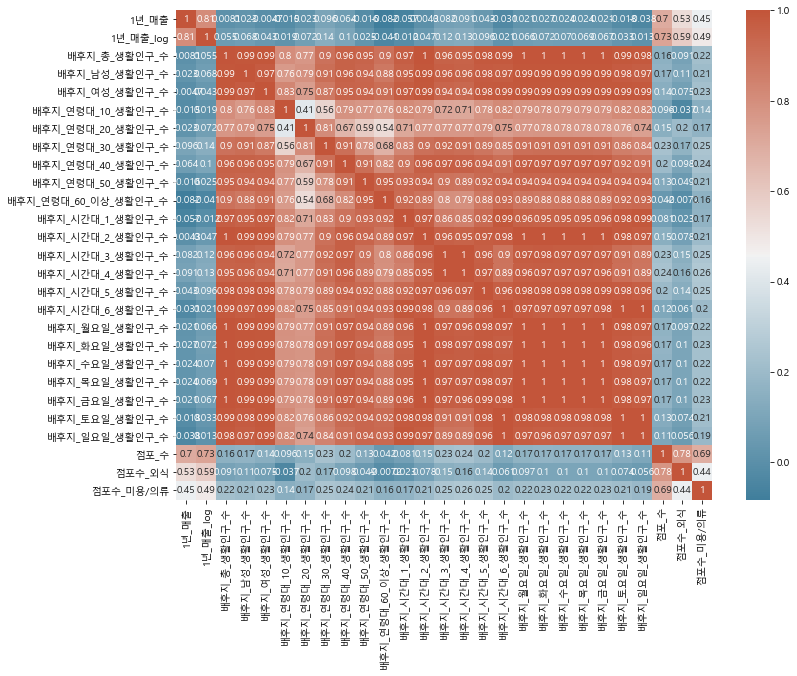

In [27]:
plt.rcParams['font.family'] = 'Malgun Gothic'
# cmap = sns.light_palette("darkgray", as_cmap=True)
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(df_all.corr(), annot=True, cmap=cmap)
plt.show()

In [28]:
df_all

,1년_매출,1년_매출_log,배후지_총_생활인구_수,배후지_남성_생활인구_수,배후지_여성_생활인구_수,배후지_연령대_10_생활인구_수,배후지_연령대_20_생활인구_수,배후지_연령대_30_생활인구_수,배후지_연령대_40_생활인구_수,배후지_연령대_50_생활인구_수,배후지_연령대_60_이상_생활인구_수,배후지_시간대_1_생활인구_수,배후지_시간대_2_생활인구_수,배후지_시간대_3_생활인구_수,배후지_시간대_4_생활인구_수,배후지_시간대_5_생활인구_수,배후지_시간대_6_생활인구_수,배후지_월요일_생활인구_수,배후지_화요일_생활인구_수,배후지_수요일_생활인구_수,배후지_목요일_생활인구_수,배후지_금요일_생활인구_수,배후지_토요일_생활인구_수,배후지_일요일_생활인구_수,점포_수,점포수_외식,점포수_미용/의류
0,1.512657e+10,23.439719,1081142.00,548255.25,532886.50,134831.50,153452.75,207655.50,217873.00,166640.00,200689.00,196188.25,241729.50,184454.00,182949.75,175165.75,100654.00,162101.00,167880.75,165795.50,165458.25,161774.00,132598.50,125534.25,204.00,52.25,32.75
1,1.599466e+10,23.495521,3643150.75,1825662.75,1817487.75,284956.00,598842.00,694745.50,623937.75,605031.25,835639.75,746978.50,764628.75,561650.00,563432.00,612312.00,394149.50,525121.75,528357.00,528595.75,526032.00,522033.00,506913.50,506097.75,113.75,13.75,24.25
2,2.874329e+10,24.081670,1732769.00,991745.25,741023.75,86649.00,322533.00,324534.75,319177.00,283800.25,396075.50,226121.25,336842.75,327960.00,345895.50,352877.50,143073.00,259865.00,271250.50,269837.50,268060.50,264725.25,218046.25,180985.00,284.00,67.25,19.00
3,1.072206e+10,23.095569,3164952.75,1481436.75,1683515.75,540905.75,948747.75,344886.75,412236.00,347404.25,570772.25,972296.25,689002.00,347553.50,317651.50,431292.25,407156.25,455354.50,457978.50,455669.75,455144.50,445046.00,441920.00,453840.75,74.25,50.25,3.00
4,1.043475e+10,23.068407,460215.00,216288.00,243927.75,67459.50,53214.75,54157.75,81447.75,78065.50,125869.50,124005.50,100354.25,54898.50,52622.50,69417.25,58917.00,64428.00,65039.00,65516.75,64755.75,65270.00,67085.00,68120.50,75.50,31.00,4.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1005,1.250092e+10,23.249068,5769453.25,2625373.75,3144080.25,1053344.50,639471.50,761018.00,870007.50,916213.25,1529398.75,1541225.75,1167899.50,659891.00,670773.00,968253.75,761410.75,811607.25,805731.75,809624.25,809589.50,810969.50,847046.00,874885.50,129.25,14.50,26.00
1006,1.723727e+10,23.570340,1411216.75,679818.00,731398.50,208156.00,155367.25,206395.75,233050.00,252466.75,355781.25,374413.50,302230.25,166217.50,160903.50,226372.75,181080.25,203808.25,203769.75,202984.25,202502.00,202081.75,197799.25,198271.50,165.75,69.75,12.75
1007,2.267043e+10,23.844327,7262764.25,3316362.00,3946403.00,912443.75,1037201.50,1229288.75,1133166.50,1114189.75,1836474.25,1796720.75,1443650.50,884636.25,906106.25,1302851.00,928799.00,1021670.75,1023656.25,1027280.50,1023607.25,1029294.50,1071366.00,1065889.50,155.00,51.00,42.00
1008,8.707442e+09,22.887444,8715362.50,3971323.00,4744039.25,1283890.75,1133539.50,1421086.00,1367469.75,1318402.50,2190974.75,2255199.25,1774693.50,1039842.50,1039749.00,1485414.75,1120463.00,1236473.00,1235512.25,1238106.75,1235409.25,1235197.75,1262281.00,1272383.75,183.00,37.00,25.00


# Stepwise

###### data 설정

In [29]:
df_X = df_all.iloc[:,2:]
df_y = df_all.iloc[:,0]

In [30]:
df_X = sm.add_constant(df_X ,has_constant = "add")
df_X

,const,배후지_총_생활인구_수,배후지_남성_생활인구_수,배후지_여성_생활인구_수,배후지_연령대_10_생활인구_수,배후지_연령대_20_생활인구_수,배후지_연령대_30_생활인구_수,배후지_연령대_40_생활인구_수,배후지_연령대_50_생활인구_수,배후지_연령대_60_이상_생활인구_수,배후지_시간대_1_생활인구_수,배후지_시간대_2_생활인구_수,배후지_시간대_3_생활인구_수,배후지_시간대_4_생활인구_수,배후지_시간대_5_생활인구_수,배후지_시간대_6_생활인구_수,배후지_월요일_생활인구_수,배후지_화요일_생활인구_수,배후지_수요일_생활인구_수,배후지_목요일_생활인구_수,배후지_금요일_생활인구_수,배후지_토요일_생활인구_수,배후지_일요일_생활인구_수,점포_수,점포수_외식,점포수_미용/의류
0,1.0,1081142.00,548255.25,532886.50,134831.50,153452.75,207655.50,217873.00,166640.00,200689.00,196188.25,241729.50,184454.00,182949.75,175165.75,100654.00,162101.00,167880.75,165795.50,165458.25,161774.00,132598.50,125534.25,204.00,52.25,32.75
1,1.0,3643150.75,1825662.75,1817487.75,284956.00,598842.00,694745.50,623937.75,605031.25,835639.75,746978.50,764628.75,561650.00,563432.00,612312.00,394149.50,525121.75,528357.00,528595.75,526032.00,522033.00,506913.50,506097.75,113.75,13.75,24.25
2,1.0,1732769.00,991745.25,741023.75,86649.00,322533.00,324534.75,319177.00,283800.25,396075.50,226121.25,336842.75,327960.00,345895.50,352877.50,143073.00,259865.00,271250.50,269837.50,268060.50,264725.25,218046.25,180985.00,284.00,67.25,19.00
3,1.0,3164952.75,1481436.75,1683515.75,540905.75,948747.75,344886.75,412236.00,347404.25,570772.25,972296.25,689002.00,347553.50,317651.50,431292.25,407156.25,455354.50,457978.50,455669.75,455144.50,445046.00,441920.00,453840.75,74.25,50.25,3.00
4,1.0,460215.00,216288.00,243927.75,67459.50,53214.75,54157.75,81447.75,78065.50,125869.50,124005.50,100354.25,54898.50,52622.50,69417.25,58917.00,64428.00,65039.00,65516.75,64755.75,65270.00,67085.00,68120.50,75.50,31.00,4.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1005,1.0,5769453.25,2625373.75,3144080.25,1053344.50,639471.50,761018.00,870007.50,916213.25,1529398.75,1541225.75,1167899.50,659891.00,670773.00,968253.75,761410.75,811607.25,805731.75,809624.25,809589.50,810969.50,847046.00,874885.50,129.25,14.50,26.00
1006,1.0,1411216.75,679818.00,731398.50,208156.00,155367.25,206395.75,233050.00,252466.75,355781.25,374413.50,302230.25,166217.50,160903.50,226372.75,181080.25,203808.25,203769.75,202984.25,202502.00,202081.75,197799.25,198271.50,165.75,69.75,12.75
1007,1.0,7262764.25,3316362.00,3946403.00,912443.75,1037201.50,1229288.75,1133166.50,1114189.75,1836474.25,1796720.75,1443650.50,884636.25,906106.25,1302851.00,928799.00,1021670.75,1023656.25,1027280.50,1023607.25,1029294.50,1071366.00,1065889.50,155.00,51.00,42.00
1008,1.0,8715362.50,3971323.00,4744039.25,1283890.75,1133539.50,1421086.00,1367469.75,1318402.50,2190974.75,2255199.25,1774693.50,1039842.50,1039749.00,1485414.75,1120463.00,1236473.00,1235512.25,1238106.75,1235409.25,1235197.75,1262281.00,1272383.75,183.00,37.00,25.00


## AIC 기반

In [31]:
def processSubset(X,y,feature_set):

    feature = list(feature_set) 
    model = sm.OLS(y,X[feature]) # Modeling
    regr = model.fit() # model fitting
    AIC = regr.aic # model's AIC
    data = regr.summary()
    return {"model" : regr, "AIC" : AIC, "SUMMARY":data, "Features":feature}
    

In [32]:
result_exam = processSubset(X = df_X, y = df_y, feature_set = df_X.columns)
result_exam['SUMMARY']

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  1년_매출   R-squared:                       0.520
Model:                            OLS   Adj. R-squared:                  0.508
Method:                 Least Squares   F-statistic:                     42.58
Date:                Mon, 11 Oct 2021   Prob (F-statistic):          9.74e-138
Time:                        17:11:55   Log-Likelihood:                -24998.
No. Observations:                1009   AIC:                         5.005e+04
Df Residuals:                     983   BIC:                         5.018e+04
Df Model:                          25                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                -3.214e+09   1.46e+09     -2.209      0.027   -6.07e+09   -3.58e+08
배후지_총_생활인구_수          5.585e+08   1.28e+09      0.437      0.662   -1.95e+09    3.07e+09
배후지_남성_생활인구_수        -1.072e+09   1.11e+09     -0.970      0.332   -3.24e+09     1.1e+09
배후지_여성_생활인구_수        -1.072e+09   1.11e+09     -0.970      0.332   -3.24e+09     1.1e+09
배후지_연령대_10_생활인구_수    -5.197e+08   7.43e+08     -0.700      0.484   -1.98e+09    9.38e+08
배후지_연령대_20_생활인구_수    -5.197e+08   7.43e+08     -0.700      0.484   -1.98e+09    9.38e+08
배후지_연령대_30_생활인구_수    -5.197e+08   7.43e+08     -0.700      0.484   -1.98e+09    9.38e+08
배후지_연령대_40_생활인구_수    -5.197e+08   7.43e+08     -0.700      0.484   -1.98e+09    9.38e+08
배후지_연령대_50_생활인구_수    -5.197e+08   7.43e+08     -0.700      0.484   -1.98e+09    9.38e+08
배후지_연령대_60_이상_생활인구_수 -5.197e+08   7.43e+08     -0.700      0.484   -1.98e+09    9.38e+08
배후지_시간대_1_생활인구_수      6.414e+08   6.83e+08      0.939      0.348   -6.98e+08    1.98e+09
배후지_시간대_2_생활인구_수      6.414e+08   6.83e+08      0.939      0.348   -6.98e+08    1.98e+09
배후지_시간대_3_생활인구_수      6.413e+08   6.83e+08      0.939      0.348   -6.98e+08    1.98e+09
배후지_시간대_4_생활인구_수      6.414e+08   6.83e+08      0.939      0.348   -6.98e+08    1.98e+09
배후지_시간대_5_생활인구_수      6.414e+08   6.83e+08      0.940      0.348   -6.98e+08    1.98e+09
배후지_시간대_6_생활인구_수      6.413e+08   6.83e+08      0.939      0.348   -6.98e+08    1.98e+09
배후지_월요일_생활인구_수        3.925e+08   6.35e+08      0.618      0.536   -8.53e+08    1.64e+09
배후지_화요일_생활인구_수        3.922e+08   6.35e+08      0.618      0.537   -8.54e+08    1.64e+09
배후지_수요일_생활인구_수        3.923e+08   6.35e+08      0.618      0.537   -8.53e+08    1.64e+09
배후지_목요일_생활인구_수        3.925e+08   6.35e+08      0.618      0.537   -8.53e+08    1.64e+09
배후지_금요일_생활인구_수        3.921e+08   6.35e+08      0.618      0.537   -8.54e+08    1.64e+09
배후지_토요일_생활인구_수        3.925e+08   6.35e+08      0.618      0.537   -8.53e+08    1.64e+09
배후지_일요일_생활인구_수        3.922e+08   6.35e+08      0.618      0.537   -8.54e+08    1.64e+09
점포_수                  2.072e+08   1.45e+07     14.286      0.000    1.79e+08    2.36e+08
점포수_외식               -1.178e+07    3.1e+07     -0.381      0.704   -7.25e+07     4.9e+07
점포수_미용/의류             -5.14e+07   4.12e+07     -1.247      0.213   -1.32e+08    2.95e+07
==============================================================================
Omnibus:                      706.007   Durbin-Watson:                   1.939
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            15247.288
Skew:                           2.918   Prob(JB):                         0.00
Kurtosis:                      21.128   Cond. No.                     3.00e+07
==============================================================================

Notes:
[1] Standard Errors 

In [33]:
result_exam['Features']

['const',
 '배후지_총_생활인구_수',
 '배후지_남성_생활인구_수',
 '배후지_여성_생활인구_수',
 '배후지_연령대_10_생활인구_수',
 '배후지_연령대_20_생활인구_수',
 '배후지_연령대_30_생활인구_수',
 '배후지_연령대_40_생활인구_수',
 '배후지_연령대_50_생활인구_수',
 '배후지_연령대_60_이상_생활인구_수',
 '배후지_시간대_1_생활인구_수',
 '배후지_시간대_2_생활인구_수',
 '배후지_시간대_3_생활인구_수',
 '배후지_시간대_4_생활인구_수',
 '배후지_시간대_5_생활인구_수',
 '배후지_시간대_6_생활인구_수',
 '배후지_월요일_생활인구_수',
 '배후지_화요일_생활인구_수',
 '배후지_수요일_생활인구_수',
 '배후지_목요일_생활인구_수',
 '배후지_금요일_생활인구_수',
 '배후지_토요일_생활인구_수',
 '배후지_일요일_생활인구_수',
 '점포_수',
 '점포수_외식',
 '점포수_미용/의류']

###### getbest()

In [34]:
import time
import itertools 

# getBest : 가장 낮은 AIC를 가지는 모델을 선택하고 저장하는 함수

def getBest(X,y,k):
    tic = time.time()      # 시작 시간
    results = []           # 결과 저장 공간
    for combo in itertools.combinations(X.columns.difference(['const']),k):
        # 각 변수 조합을 고려한 경우의수
        
        combo = (list(combo)+['const'])
        # 상수항을 추가하여 combo를 결성
        
        results.append(processSubset(X,y,feature_set = combo)) # 모델링된것을 저장
        
        # 만약 k=2이면 여기서 두가지 변수만 뽑아서 경우의 수를 분석하여
        # 저장 후 그 중 AIC가 가장 낮은 모델을 선택하도록 함

    models = pd.DataFrame(results) # 데이터프레임으로 모델결과 변환
    best_model = models.loc[models['AIC'].argmin()] # argmin은 최소값의 인덱스를 뽑는 함수
    toc = time.time()       # 종료 시간
    print("Processed", models.shape[0], "models on", k, "predictors in",(toc - tic),"seconds.")
    
    return best_model

In [35]:
b_model = getBest(X=df_X, y = df_y, k=3)

Processed 2300 models on 3 predictors in 6.729029655456543 seconds.


In [36]:
b_model['SUMMARY']

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  1년_매출   R-squared:                       0.510
Model:                            OLS   Adj. R-squared:                  0.509
Method:                 Least Squares   F-statistic:                     349.0
Date:                Mon, 11 Oct 2021   Prob (F-statistic):          2.98e-155
Time:                        17:12:02   Log-Likelihood:                -25009.
No. Observations:                1009   AIC:                         5.003e+04
Df Residuals:                    1005   BIC:                         5.004e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
배후지_일요일_생활인구_수 -7.698e+04   2.54e+04     -3.036      0.002   -1.27e+05   -2.72e+04
배후지_토요일_생활인구_수  7.091e+04   2.61e+04      2.722      0.007    1.98e+04    1.22e+05
점포_수            1.979e+08    6.8e+06     29.129      0.000    1.85e+08    2.11e+08
const          -2.849e+09   1.36e+09     -2.094      0.037   -5.52e+09   -1.79e+08
==============================================================================
Omnibus:                      711.744   Durbin-Watson:                   1.918
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            15164.428
Skew:                           2.959   Prob(JB):                         0.00
Kurtosis:                      21.046   Cond. No.                     3.07e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.07e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [37]:
### 전진석택법(step=1)

def forward(X,y,predictors):

    # predictor - 현재 선택되어있는 변수
    # 데이터 변수들이 미리정의된 predictors에 있는지 없는지 확인 및 분류
    
    remaining_predictors = [p for p in X.columns.difference(['const']) if p not in predictors]
    tic = time.time()
    results = []
    for p in remaining_predictors :
        results.append(processSubset(X=X,y=y,feature_set=predictors+[p]+['const']))
    
    # 데이터프레임으로 변환
    models = pd.DataFrame(results)
    
    # AIC가 가장 낮은 것을 선택
    best_model = models.loc[models['AIC'].argmin()]
    toc = time.time()
    print("Processed ",models.shape[0], "models on", len(predictors)+1, "predictors in", (toc-tic))
    print("Selected predictors:",best_model["model"].model.exog_names,"AIC: ",best_model[0])
    return best_model
    
### 전진선택법 모델

def forward_model(X,y):

    Fmodels = pd.DataFrame(columns=["AIC","model","SUMMARY",'Features'])
    tic = time.time()
    
    # 미리 정의된 데이터 변수
    predictors = []
    
    # 변수 1~10개 : 0-9 -> 1-10
    for i in range(1,len(X.columns.difference(['const']))+1):
        Forward_result = forward(X=X,y=y,predictors=predictors)
        if i > 1 :
            if Forward_result["AIC"] > Fmodel_before:
                break
        Fmodels.loc[i] = Forward_result
        predictors = Fmodels.loc[i]["model"].model.exog_names
        Fmodel_before = Fmodels.loc[i]["AIC"]
        predictors = [k for k in predictors if k != 'const']
    toc = time.time()
    print("Total elapsed time:",(toc-tic), "seconds.")
    return Fmodels
#     return (Fmodels['model'][len(Fmodels['model'])])


b_forward = forward_model(df_X, df_y)

In [38]:
def vis_AIC_step(result):
    fig = plt.figure(figsize=(10,10))
    fig.set_facecolor('white')
 
    font_size = 15
    steps = range(1, result.shape[0]+1)
    AIC  = result['AIC'].to_list()
    features = [f'step {i+1}\n'+'\n'.join(s) for i,s in enumerate(result['Features'])]
    
    plt.xticks(steps, features, fontsize=12)
    plt.plot(steps,AIC, marker='o')
    
    plt.ylabel('AIC',fontsize=font_size)
    plt.grid(True)
    plt.show()
 

vis_AIC_step(b_forward)

In [39]:
### 후진소거법(step=1)

def backward(X,y,predictors):
    tic = time.time()
    results = []
    
    # 데이터 변수들이 미리 정의된 predictors 조합 확인
    
    for combo in itertools.combinations(predictors, len(predictors) - 1):
        results.append(processSubset(X=X,y=y,feature_set=list(combo)+['const']))
    models = pd.DataFrame(results)
    
    # 가장 낮은 AIC를 가진 모델을 선택
    best_model = models.loc[models['AIC'].argmin()]
    toc = time.time()
    
    print("Processed ",models.shape[0], "models on", len(predictors) - 1, "predictors in",(toc-tic))
    print("Selected predictors:",best_model['model'].model.exog_names,' AIC:',best_model[0])
    return best_model
    
def backward_model(X,y) :
    Bmodels = pd.DataFrame(columns=["AIC","model","SUMMARY","Features"], index = range(1,len(X.columns)))
    tic = time.time()
    predictors = X.columns.difference(['const'])
    Bmodel_before = processSubset(X,y,predictors)['AIC']
    while (len(predictors) > 1):
        Backward_result = backward(X=X, y= y, predictors=predictors)
        if Backward_result['AIC'] > Bmodel_before :
            break
        Bmodels.loc[len(predictors) -1] = Backward_result
        predictors = Bmodels.loc[len(predictors) - 1]['model'].model.exog_names
        Bmodel_before = Backward_result["AIC"]
        predictors = [k for k in predictors if k != 'const']
    
    toc = time.time()
    print("Total elapsed time:",(toc-tic),"seconds.")
    return Bmodels.dropna()
#     return Bmodels["model"].dropna().iloc[0]

In [69]:
### 후진소거법(step=1)

def backward(X,y,predictors):
    tic = time.time()
    results = []
    
    # 데이터 변수들이 미리 정의된 predictors 조합 확인
    
    for combo in itertools.combinations(predictors, len(predictors) - 1):
        results.append(processSubset(X=X,y=y,feature_set=list(combo)+['const']))
    models = pd.DataFrame(results)
    
    # 가장 낮은 AIC를 가진 모델을 선택
    best_model = models.loc[models['AIC'].argmin()]
    toc = time.time()
    
    print("Processed ",models.shape[0], "models on", len(predictors) - 1, "predictors in",(toc-tic))
    print("Selected predictors:",best_model['model'].model.exog_names,' AIC:',best_model[0])
    return best_model
    
def backward_model(X,y) :
    Bmodels = pd.DataFrame(columns=["AIC","model","SUMMARY","Features"], index = range(1,len(X.columns)))
    tic = time.time()
    predictors = X.columns.difference(['const'])
    Bmodel_before = processSubset(X,y,predictors)['AIC']
    idx = 1
    while (len(predictors) > 1):
        Backward_result = backward(X=X, y= y, predictors=predictors)
        if Backward_result['AIC'] > Bmodel_before :
            break
        Bmodels.loc[idx] = Backward_result
        predictors = Bmodels.loc[idx]['model'].model.exog_names
        Bmodel_before = Backward_result["AIC"]
        predictors = [k for k in predictors if k != 'const']
        idx+=1
    
    toc = time.time()
    print("Total elapsed time:",(toc-tic),"seconds.")
    return Bmodels.dropna()
#     return Bmodels["model"].dropna().iloc[0]

b_model = backward_model(df_X, df_y)

vis_AIC_step(b_model)

In [40]:
def Stepwise_model(X,y):
    Stepmodels = pd.DataFrame(columns = ["AIC","model","SUMMARY",'Features'])
    tic = time.time()
    predictors = []
    Stepmodels.loc[1] = getBest(X,y,k=1)
#     Smodel_before = processSubset(X,y,predictors + ['const'])['AIC']
    predictors = Stepmodels.loc[1]['model'].model.exog_names
    predictors = [k for k in predictors if k != "const"]
    print(predictors)
    Smodel_before = Stepmodels.loc[1]['AIC']
    
    # 변수 1~10개 0-9 -> 1-10
    for i in range(1,len(X.columns.difference(['const']))+1) :
        print('step:',i-1)

        Forward_result = forward(X=X,y=y,predictors = predictors ) # constant added
        
        
        predictors = Stepmodels.loc[i]['model'].model.exog_names
        predictors = [k for k in predictors if k != 'const']
        
        print(predictors)
        
        Backward_result = backward(X=X,y=y,predictors = predictors)
        
        
        if Backward_result["AIC"] < Forward_result["AIC"]:
            Stepmodels.loc[i] = Backward_result
            predictors = Stepmodels.loc[i]["model"].model.exog_names
            Smodel_before = Stepmodels.loc[i]["AIC"]
            predictors = [k for k in predictors if k != "const"]
            print('backward')
        if Stepmodels.loc[i]["AIC"] > Smodel_before:
            break
        else :
            Smodel_before = Stepmodels.loc[i]["AIC"]
            print('##forward##')
    toc = time.time()
    print("Total elapsed time:",(toc-tic),"seconds.")
    return Stepmodels
#     return (Stepmodels["model"][len(Stepmodels["model"])])

In [41]:
def Stepwise_model(X,y):
    Stepmodels = pd.DataFrame(columns = ["AIC","model","SUMMARY",'Features'])
    tic = time.time()
    predictors = []
    Stepmodels.loc[1] = getBest(X,y,k=1)
#     Smodel_before = processSubset(X,y,predictors + ['const'])['AIC']
    predictors = Stepmodels.loc[1]['model'].model.exog_names
    predictors = [k for k in predictors if k != "const"]
    print(predictors)
    Smodel_before = Stepmodels.loc[1]['AIC']
    
    # 변수 1~10개 0-9 -> 1-10
    for i in range(2,len(X.columns.difference(['const']))+1) :
        print('step:',i-1)

        Forward_result = forward(X=X,y=y,predictors = predictors ) # constant added
        Backward_result = backward(X=X,y=y,predictors = predictors)
        
        
        if Backward_result["AIC"] < Forward_result["AIC"]:
            Stepmodels.loc[i] = Backward_result
            predictors = Stepmodels.loc[i]["model"].model.exog_names
            predictors = [k for k in predictors if k != "const"]
            print('backward')
            
        else:
            Stepmodels.loc[i] = Forward_result
            predictors = Stepmodels.loc[i]["model"].model.exog_names
            predictors = [k for k in predictors if k != "const"]
            print('##forward##')
            
        if Stepmodels.loc[i]["AIC"] > Smodel_before:
            break
        else :
            Smodel_before = Stepmodels.loc[i]["AIC"]
            
    toc = time.time()
    print("Total elapsed time:",(toc-tic),"seconds.")
    return Stepmodels
#     return (Stepmodels["model"][len(Stepmodels["model"])])

In [42]:
s_model = Stepwise_model(df_X, df_y)

Processed 25 models on 1 predictors in 0.07406735420227051 seconds.
['점포_수']
step: 1
Processed  24 models on 2 predictors in 0.06305718421936035
Selected predictors: ['점포_수', '배후지_시간대_1_생활인구_수', 'const'] AIC:  <statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x000001E6FB1E5A60>
Processed  1 models on 0 predictors in 0.005006074905395508
Selected predictors: ['const']  AIC: <statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x000001E6F825DB50>
##forward##
step: 2
Processed  23 models on 3 predictors in 0.056051015853881836
Selected predictors: ['점포_수', '배후지_시간대_1_생활인구_수', '배후지_연령대_40_생활인구_수', 'const'] AIC:  <statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x000001E6F936BA00>
Processed  2 models on 1 predictors in 0.006005764007568359
Selected predictors: ['점포_수', 'const']  AIC: <statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x000001E6F82844C0>
##forward##
step: 3
Processed  22 models on 4 predict

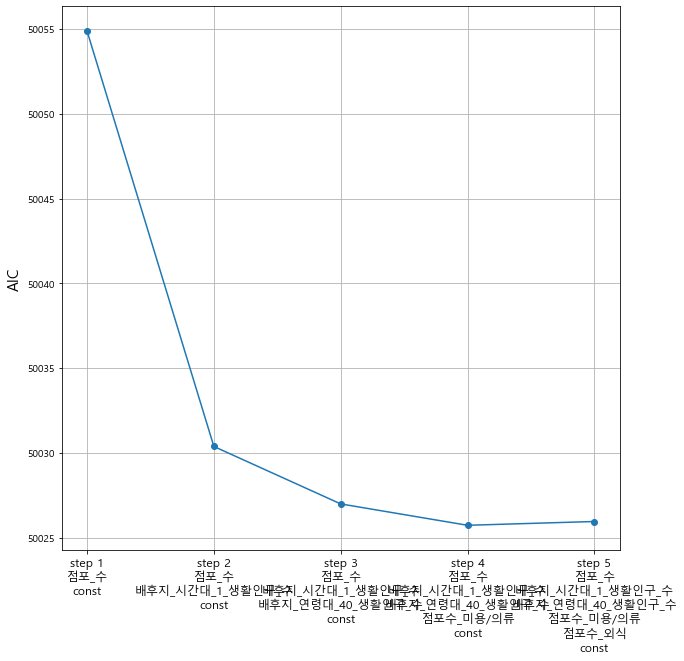

In [43]:
vis_AIC_step(s_model)

## R-square 기반

In [44]:
df_X

,const,배후지_총_생활인구_수,배후지_남성_생활인구_수,배후지_여성_생활인구_수,배후지_연령대_10_생활인구_수,배후지_연령대_20_생활인구_수,배후지_연령대_30_생활인구_수,배후지_연령대_40_생활인구_수,배후지_연령대_50_생활인구_수,배후지_연령대_60_이상_생활인구_수,배후지_시간대_1_생활인구_수,배후지_시간대_2_생활인구_수,배후지_시간대_3_생활인구_수,배후지_시간대_4_생활인구_수,배후지_시간대_5_생활인구_수,배후지_시간대_6_생활인구_수,배후지_월요일_생활인구_수,배후지_화요일_생활인구_수,배후지_수요일_생활인구_수,배후지_목요일_생활인구_수,배후지_금요일_생활인구_수,배후지_토요일_생활인구_수,배후지_일요일_생활인구_수,점포_수,점포수_외식,점포수_미용/의류
0,1.0,1081142.00,548255.25,532886.50,134831.50,153452.75,207655.50,217873.00,166640.00,200689.00,196188.25,241729.50,184454.00,182949.75,175165.75,100654.00,162101.00,167880.75,165795.50,165458.25,161774.00,132598.50,125534.25,204.00,52.25,32.75
1,1.0,3643150.75,1825662.75,1817487.75,284956.00,598842.00,694745.50,623937.75,605031.25,835639.75,746978.50,764628.75,561650.00,563432.00,612312.00,394149.50,525121.75,528357.00,528595.75,526032.00,522033.00,506913.50,506097.75,113.75,13.75,24.25
2,1.0,1732769.00,991745.25,741023.75,86649.00,322533.00,324534.75,319177.00,283800.25,396075.50,226121.25,336842.75,327960.00,345895.50,352877.50,143073.00,259865.00,271250.50,269837.50,268060.50,264725.25,218046.25,180985.00,284.00,67.25,19.00
3,1.0,3164952.75,1481436.75,1683515.75,540905.75,948747.75,344886.75,412236.00,347404.25,570772.25,972296.25,689002.00,347553.50,317651.50,431292.25,407156.25,455354.50,457978.50,455669.75,455144.50,445046.00,441920.00,453840.75,74.25,50.25,3.00
4,1.0,460215.00,216288.00,243927.75,67459.50,53214.75,54157.75,81447.75,78065.50,125869.50,124005.50,100354.25,54898.50,52622.50,69417.25,58917.00,64428.00,65039.00,65516.75,64755.75,65270.00,67085.00,68120.50,75.50,31.00,4.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1005,1.0,5769453.25,2625373.75,3144080.25,1053344.50,639471.50,761018.00,870007.50,916213.25,1529398.75,1541225.75,1167899.50,659891.00,670773.00,968253.75,761410.75,811607.25,805731.75,809624.25,809589.50,810969.50,847046.00,874885.50,129.25,14.50,26.00
1006,1.0,1411216.75,679818.00,731398.50,208156.00,155367.25,206395.75,233050.00,252466.75,355781.25,374413.50,302230.25,166217.50,160903.50,226372.75,181080.25,203808.25,203769.75,202984.25,202502.00,202081.75,197799.25,198271.50,165.75,69.75,12.75
1007,1.0,7262764.25,3316362.00,3946403.00,912443.75,1037201.50,1229288.75,1133166.50,1114189.75,1836474.25,1796720.75,1443650.50,884636.25,906106.25,1302851.00,928799.00,1021670.75,1023656.25,1027280.50,1023607.25,1029294.50,1071366.00,1065889.50,155.00,51.00,42.00
1008,1.0,8715362.50,3971323.00,4744039.25,1283890.75,1133539.50,1421086.00,1367469.75,1318402.50,2190974.75,2255199.25,1774693.50,1039842.50,1039749.00,1485414.75,1120463.00,1236473.00,1235512.25,1238106.75,1235409.25,1235197.75,1262281.00,1272383.75,183.00,37.00,25.00


In [45]:
df_y

0       1.512657e+10
1       1.599466e+10
2       2.874329e+10
3       1.072206e+10
4       1.043475e+10
            ...     
1005    1.250092e+10
1006    1.723727e+10
1007    2.267043e+10
1008    8.707442e+09
1009    1.232662e+10
Name: 1년_매출, Length: 1009, dtype: float64

In [46]:
## 전진 선택법
variables = df_X.columns.tolist() ## 설명 변수 리스트
 
# df_y= df['Survival_Time'] ## 반응 변수
selected_variables = [] ## 선택된 변수들
sl_enter = 0.05
 
sv_per_step = [] ## 각 스텝별로 선택된 변수들
adjusted_r_squared = [] ## 각 스텝별 수정된 결정계수
steps = [] ## 스텝
step = 0
while len(variables) > 0:
    remainder = list(set(variables) - set(selected_variables))
    pval = pd.Series(index=remainder) ## 변수의 p-value
    ## 기존에 포함된 변수와 새로운 변수 하나씩 돌아가면서 
    ## 선형 모형을 적합한다.
    for col in remainder: 
        X = df_X[selected_variables+[col]]
        X = sm.add_constant(X)
        model = sm.OLS(df_y,X).fit()
        pval[col] = model.pvalues[col]
 
    min_pval = pval.min()
    if min_pval < sl_enter: ## 최소 p-value 값이 기준 값보다 작으면 포함
        selected_variables.append(pval.idxmin())
        
        step += 1
        steps.append(step)
        adj_r_squared = sm.OLS(df_y,sm.add_constant(df_X[selected_variables])).fit().rsquared_adj
        adjusted_r_squared.append(adj_r_squared)
        sv_per_step.append(selected_variables.copy())
    else:
        break

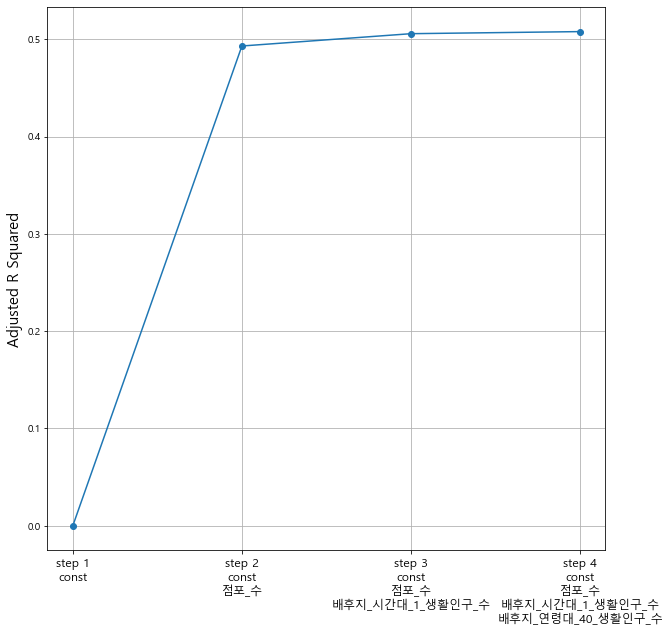

In [47]:
fig = plt.figure(figsize=(10,10))
fig.set_facecolor('white')
 
font_size = 15
plt.xticks(steps,[f'step {s}\n'+'\n'.join(sv_per_step[i]) for i,s in enumerate(steps)], fontsize=12)
plt.plot(steps,adjusted_r_squared, marker='o')
    
plt.ylabel('Adjusted R Squared',fontsize=font_size)
plt.grid(True)
plt.show()

In [48]:
## 후진 소거법
variables = df_X.columns[:-2].tolist() ## 설명 변수 리스트
 
# df_y= df_X['Survival_Time'] ## 반응 변수
selected_variables = variables ## 초기에는 모든 변수가 선택된 상태
sl_remove = 0.05
 
sv_per_step = [] ## 각 스텝별로 선택된 변수들
adjusted_r_squared = [] ## 각 스텝별 수정된 결정계수
steps = [] ## 스텝
step = 0
while len(selected_variables) > 0:
    X = sm.add_constant(df_X[selected_variables])
    p_vals = sm.OLS(df_y,X).fit().pvalues[1:] ## 절편항의 p-value는 뺀다
    max_pval = p_vals.max() ## 최대 p-value
    if max_pval >= sl_remove: ## 최대 p-value값이 기준값보다 크거나 같으면 제외
        remove_variable = p_vals.idxmax()
        selected_variables.remove(remove_variable)
 
        step += 1
        steps.append(step)
        adj_r_squared = sm.OLS(df_y,sm.add_constant(df_X[selected_variables])).fit().rsquared_adj
        adjusted_r_squared.append(adj_r_squared)
        sv_per_step.append(selected_variables.copy())
    else:
        break

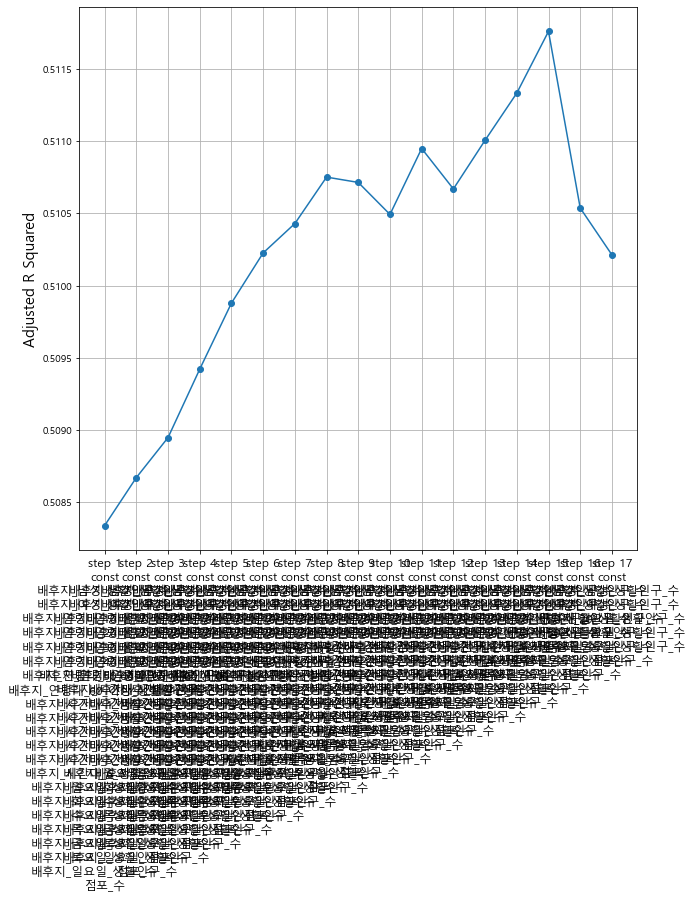

In [49]:
fig = plt.figure(figsize=(10,10))
fig.set_facecolor('white')
 
font_size = 15
plt.xticks(steps,[f'step {s}\n'+'\n'.join(sv_per_step[i]) for i,s in enumerate(steps)], fontsize=12)
plt.plot(steps,adjusted_r_squared, marker='o')
    
plt.ylabel('Adjusted R Squared',fontsize=font_size)
plt.grid(True)
plt.show()

In [50]:
## 전진 단계별 선택법
variables = df_X.columns[:-2].tolist() ## 설명 변수 리스트
 
# df_y= df_X['Survival_Time'] ## 반응 변수
selected_variables = [] ## 선택된 변수들
sl_enter = 0.05
sl_remove = 0.05
 
sv_per_step = [] ## 각 스텝별로 선택된 변수들
adjusted_r_squared = [] ## 각 스텝별 수정된 결정계수
steps = [] ## 스텝
step = 0
while len(variables) > 0:
    remainder = list(set(variables) - set(selected_variables))
    pval = pd.Series(index=remainder) ## 변수의 p-value
    ## 기존에 포함된 변수와 새로운 변수 하나씩 돌아가면서 
    ## 선형 모형을 적합한다.
    for col in remainder: 
        X = df_X[selected_variables+[col]]
        X = sm.add_constant(X)
        model = sm.OLS(df_y,X).fit()
        pval[col] = model.pvalues[col]
 
    min_pval = pval.min()
    if min_pval < sl_enter: ## 최소 p-value 값이 기준 값보다 작으면 포함
        selected_variables.append(pval.idxmin())
        ## 선택된 변수들에대해서
        ## 어떤 변수를 제거할지 고른다.
        while len(selected_variables) > 0:
            selected_X = df_X[selected_variables]
            selected_X = sm.add_constant(selected_X)
            selected_pval = sm.OLS(df_y,selected_X).fit().pvalues[1:] ## 절편항의 p-value는 뺀다
            max_pval = selected_pval.max()
            if max_pval >= sl_remove: ## 최대 p-value값이 기준값보다 크거나 같으면 제외
                remove_variable = selected_pval.idxmax()
                selected_variables.remove(remove_variable)
            else:
                break
        
        step += 1
        steps.append(step)
        adj_r_squared = sm.OLS(df_y,sm.add_constant(df_X[selected_variables])).fit().rsquared_adj
        adjusted_r_squared.append(adj_r_squared)
        sv_per_step.append(selected_variables.copy())
    else:
        break

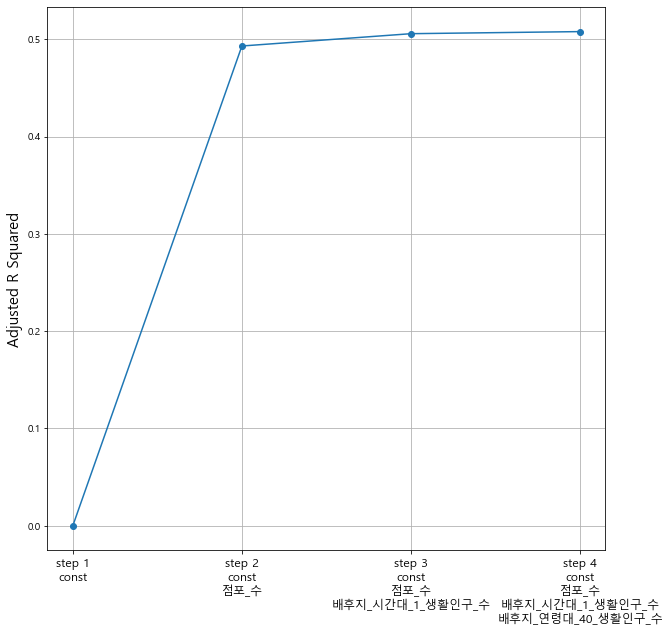

In [51]:
fig = plt.figure(figsize=(10,10))
fig.set_facecolor('white')
 
font_size = 15
plt.xticks(steps,[f'step {s}\n'+'\n'.join(sv_per_step[i]) for i,s in enumerate(steps)], fontsize=12)
plt.plot(steps,adjusted_r_squared, marker='o')
    
plt.ylabel('Adjusted R Squared',fontsize=font_size)
plt.grid(True)
plt.show()

----------------------------------------------------

# New Target 매출_회귀계수

In [52]:
df_t_total = pd.read_csv('data/j_result/매출_회귀계수.csv')
df_t_total = get_object_type(df_t_total)
df_t_total.head(3)

,상권_코드,coef
0,1000001,-9.708293e+07
1,1000002,-3.237588e+08
2,1000003,-2.785227e+08


In [53]:
df_pre.head()

,상권_코드,1년_매출,1년_매출_log,배후지_총_생활인구_수,배후지_남성_생활인구_수,배후지_여성_생활인구_수,배후지_연령대_10_생활인구_수,배후지_연령대_20_생활인구_수,배후지_연령대_30_생활인구_수,배후지_연령대_40_생활인구_수,배후지_연령대_50_생활인구_수,배후지_연령대_60_이상_생활인구_수,배후지_시간대_1_생활인구_수,배후지_시간대_2_생활인구_수,배후지_시간대_3_생활인구_수,배후지_시간대_4_생활인구_수,배후지_시간대_5_생활인구_수,배후지_시간대_6_생활인구_수,배후지_월요일_생활인구_수,배후지_화요일_생활인구_수,배후지_수요일_생활인구_수,배후지_목요일_생활인구_수,배후지_금요일_생활인구_수,배후지_토요일_생활인구_수,배후지_일요일_생활인구_수,점포_수,점포수_외식,점포수_미용/의류
0,1000001,1.512657e+10,23.439719,1081142.00,548255.25,532886.50,134831.50,153452.75,207655.50,217873.00,166640.00,200689.00,196188.25,241729.50,184454.0,182949.75,175165.75,100654.00,162101.00,167880.75,165795.50,165458.25,161774.00,132598.50,125534.25,204.00,52.25,32.75
1,1000002,1.599466e+10,23.495521,3643150.75,1825662.75,1817487.75,284956.00,598842.00,694745.50,623937.75,605031.25,835639.75,746978.50,764628.75,561650.0,563432.00,612312.00,394149.50,525121.75,528357.00,528595.75,526032.00,522033.00,506913.50,506097.75,113.75,13.75,24.25
2,1000003,2.874329e+10,24.081670,1732769.00,991745.25,741023.75,86649.00,322533.00,324534.75,319177.00,283800.25,396075.50,226121.25,336842.75,327960.0,345895.50,352877.50,143073.00,259865.00,271250.50,269837.50,268060.50,264725.25,218046.25,180985.00,284.00,67.25,19.00
3,1000004,1.072206e+10,23.095569,3164952.75,1481436.75,1683515.75,540905.75,948747.75,344886.75,412236.00,347404.25,570772.25,972296.25,689002.00,347553.5,317651.50,431292.25,407156.25,455354.50,457978.50,455669.75,455144.50,445046.00,441920.00,453840.75,74.25,50.25,3.00
4,1000005,1.043475e+10,23.068407,460215.00,216288.00,243927.75,67459.50,53214.75,54157.75,81447.75,78065.50,125869.50,124005.50,100354.25,54898.5,52622.50,69417.25,58917.00,64428.00,65039.00,65516.75,64755.75,65270.00,67085.00,68120.50,75.50,31.00,4.00


In [54]:
df_newtarget1 = pd.merge(df_pre, df_t_total, how='left',on='상권_코드')
df_newtarget1.head(3)

,상권_코드,1년_매출,1년_매출_log,배후지_총_생활인구_수,배후지_남성_생활인구_수,배후지_여성_생활인구_수,배후지_연령대_10_생활인구_수,배후지_연령대_20_생활인구_수,배후지_연령대_30_생활인구_수,배후지_연령대_40_생활인구_수,배후지_연령대_50_생활인구_수,배후지_연령대_60_이상_생활인구_수,배후지_시간대_1_생활인구_수,배후지_시간대_2_생활인구_수,배후지_시간대_3_생활인구_수,배후지_시간대_4_생활인구_수,배후지_시간대_5_생활인구_수,배후지_시간대_6_생활인구_수,배후지_월요일_생활인구_수,배후지_화요일_생활인구_수,배후지_수요일_생활인구_수,배후지_목요일_생활인구_수,배후지_금요일_생활인구_수,배후지_토요일_생활인구_수,배후지_일요일_생활인구_수,점포_수,점포수_외식,점포수_미용/의류,coef
0,1000001,1.512657e+10,23.439719,1081142.00,548255.25,532886.50,134831.5,153452.75,207655.50,217873.00,166640.00,200689.00,196188.25,241729.50,184454.0,182949.75,175165.75,100654.0,162101.00,167880.75,165795.50,165458.25,161774.00,132598.50,125534.25,204.00,52.25,32.75,-9.708293e+07
1,1000002,1.599466e+10,23.495521,3643150.75,1825662.75,1817487.75,284956.0,598842.00,694745.50,623937.75,605031.25,835639.75,746978.50,764628.75,561650.0,563432.00,612312.00,394149.5,525121.75,528357.00,528595.75,526032.00,522033.00,506913.50,506097.75,113.75,13.75,24.25,-3.237588e+08
2,1000003,2.874329e+10,24.081670,1732769.00,991745.25,741023.75,86649.0,322533.00,324534.75,319177.00,283800.25,396075.50,226121.25,336842.75,327960.0,345895.50,352877.50,143073.0,259865.00,271250.50,269837.50,268060.50,264725.25,218046.25,180985.00,284.00,67.25,19.00,-2.785227e+08


In [59]:
df_newtarget1.dropna(inplace=True, axis=0)
df_X = df_newtarget1.iloc[:, 1:-1]
df_y = df_newtarget1.iloc[:,-1]


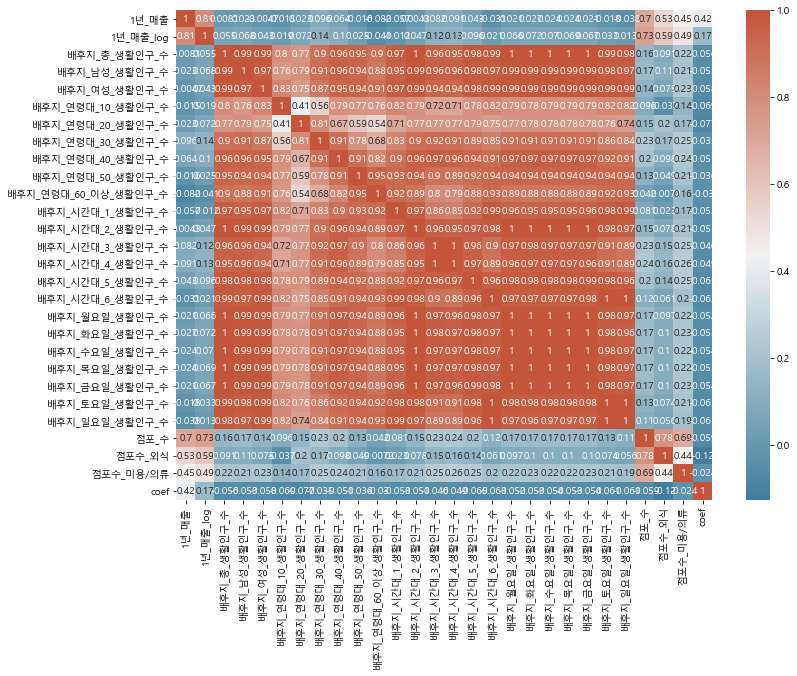

In [68]:
get_VIF(df_newtarget1)

In [60]:
df_X = sm.add_constant(df_X ,has_constant = "add")
df_X.head()

,const,1년_매출,1년_매출_log,배후지_총_생활인구_수,배후지_남성_생활인구_수,배후지_여성_생활인구_수,배후지_연령대_10_생활인구_수,배후지_연령대_20_생활인구_수,배후지_연령대_30_생활인구_수,배후지_연령대_40_생활인구_수,배후지_연령대_50_생활인구_수,배후지_연령대_60_이상_생활인구_수,배후지_시간대_1_생활인구_수,배후지_시간대_2_생활인구_수,배후지_시간대_3_생활인구_수,배후지_시간대_4_생활인구_수,배후지_시간대_5_생활인구_수,배후지_시간대_6_생활인구_수,배후지_월요일_생활인구_수,배후지_화요일_생활인구_수,배후지_수요일_생활인구_수,배후지_목요일_생활인구_수,배후지_금요일_생활인구_수,배후지_토요일_생활인구_수,배후지_일요일_생활인구_수,점포_수,점포수_외식,점포수_미용/의류
0,1.0,1.512657e+10,23.439719,1081142.00,548255.25,532886.50,134831.50,153452.75,207655.50,217873.00,166640.00,200689.00,196188.25,241729.50,184454.0,182949.75,175165.75,100654.00,162101.00,167880.75,165795.50,165458.25,161774.00,132598.50,125534.25,204.00,52.25,32.75
1,1.0,1.599466e+10,23.495521,3643150.75,1825662.75,1817487.75,284956.00,598842.00,694745.50,623937.75,605031.25,835639.75,746978.50,764628.75,561650.0,563432.00,612312.00,394149.50,525121.75,528357.00,528595.75,526032.00,522033.00,506913.50,506097.75,113.75,13.75,24.25
2,1.0,2.874329e+10,24.081670,1732769.00,991745.25,741023.75,86649.00,322533.00,324534.75,319177.00,283800.25,396075.50,226121.25,336842.75,327960.0,345895.50,352877.50,143073.00,259865.00,271250.50,269837.50,268060.50,264725.25,218046.25,180985.00,284.00,67.25,19.00
3,1.0,1.072206e+10,23.095569,3164952.75,1481436.75,1683515.75,540905.75,948747.75,344886.75,412236.00,347404.25,570772.25,972296.25,689002.00,347553.5,317651.50,431292.25,407156.25,455354.50,457978.50,455669.75,455144.50,445046.00,441920.00,453840.75,74.25,50.25,3.00
4,1.0,1.043475e+10,23.068407,460215.00,216288.00,243927.75,67459.50,53214.75,54157.75,81447.75,78065.50,125869.50,124005.50,100354.25,54898.5,52622.50,69417.25,58917.00,64428.00,65039.00,65516.75,64755.75,65270.00,67085.00,68120.50,75.50,31.00,4.00


In [61]:
df_y

0      -9.708293e+07
1      -3.237588e+08
2      -2.785227e+08
3      -1.485081e+08
4      -1.627068e+08
            ...     
1005   -1.661354e+08
1006    6.801529e+06
1007   -2.434822e+08
1008   -2.808131e+08
1009    3.427119e+07
Name: coef, Length: 1009, dtype: float64

In [62]:
b_model2 = backward_model(df_X, df_y)

Processed  27 models on 26 predictors in 0.09308362007141113
Selected predictors: ['1년_매출', '1년_매출_log', '배후지_금요일_생활인구_수', '배후지_남성_생활인구_수', '배후지_목요일_생활인구_수', '배후지_수요일_생활인구_수', '배후지_시간대_1_생활인구_수', '배후지_시간대_2_생활인구_수', '배후지_시간대_3_생활인구_수', '배후지_시간대_4_생활인구_수', '배후지_시간대_5_생활인구_수', '배후지_시간대_6_생활인구_수', '배후지_연령대_10_생활인구_수', '배후지_연령대_20_생활인구_수', '배후지_연령대_30_생활인구_수', '배후지_연령대_40_생활인구_수', '배후지_연령대_50_생활인구_수', '배후지_연령대_60_이상_생활인구_수', '배후지_월요일_생활인구_수', '배후지_일요일_생활인구_수', '배후지_총_생활인구_수', '배후지_토요일_생활인구_수', '배후지_화요일_생활인구_수', '점포_수', '점포수_미용/의류', '점포수_외식', 'const']  AIC: <statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x000001E6FE6329D0>
Processed  26 models on 25 predictors in 0.089080810546875
Selected predictors: ['1년_매출', '1년_매출_log', '배후지_금요일_생활인구_수', '배후지_목요일_생활인구_수', '배후지_수요일_생활인구_수', '배후지_시간대_1_생활인구_수', '배후지_시간대_2_생활인구_수', '배후지_시간대_3_생활인구_수', '배후지_시간대_4_생활인구_수', '배후지_시간대_5_생활인구_수', '배후지_시간대_6_생활인구_수', '배후지_연령대_10_생활인구_수', '배후지_연령대_20_생활인구_수', '배후지_연령대_30_생활인구_수', '배후지_연령대_

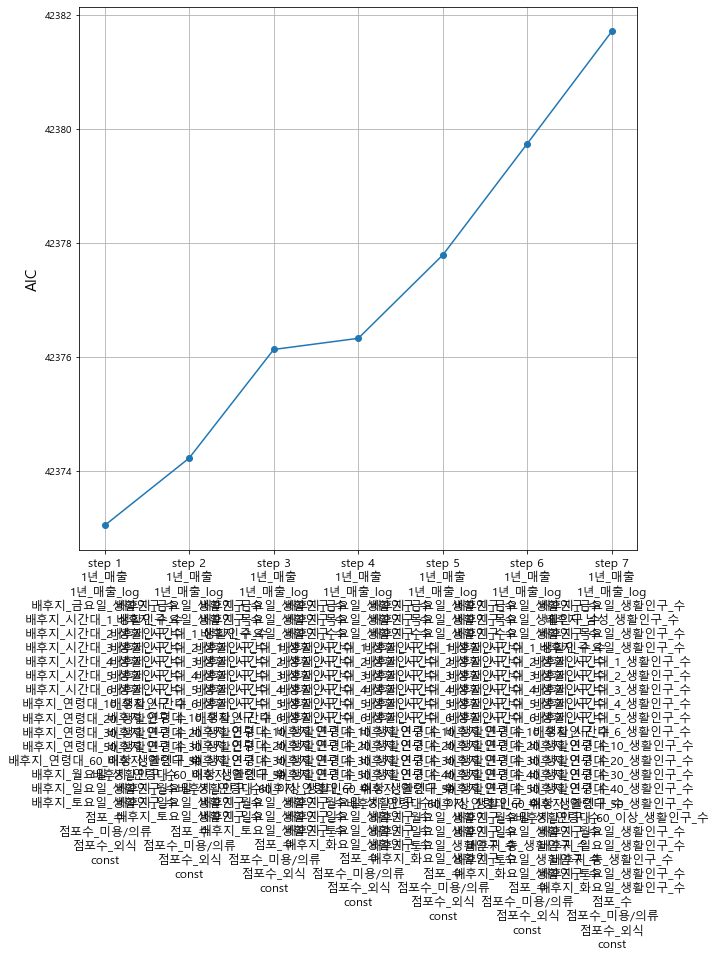

In [64]:
vis_AIC_step(b_model2)

In [65]:
s_model2 = Stepwise_model(df_X, df_y)

Processed 27 models on 1 predictors in 0.06313252449035645 seconds.
['1년_매출']
step: 1
Processed  26 models on 2 predictors in 0.0640571117401123
Selected predictors: ['1년_매출', '점포_수', 'const'] AIC:  <statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x000001E6FB3C6550>
Processed  1 models on 0 predictors in 0.0030035972595214844
Selected predictors: ['const']  AIC: <statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x000001E6FB1B08B0>
##forward##
step: 2
Processed  25 models on 3 predictors in 0.07306647300720215
Selected predictors: ['1년_매출', '점포_수', '점포수_외식', 'const'] AIC:  <statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x000001E6F9448E20>
Processed  2 models on 1 predictors in 0.005006551742553711
Selected predictors: ['1년_매출', 'const']  AIC: <statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x000001E6FB0F42E0>
##forward##
step: 3
Processed  24 models on 4 predictors in 0.06006956100463867
Selec

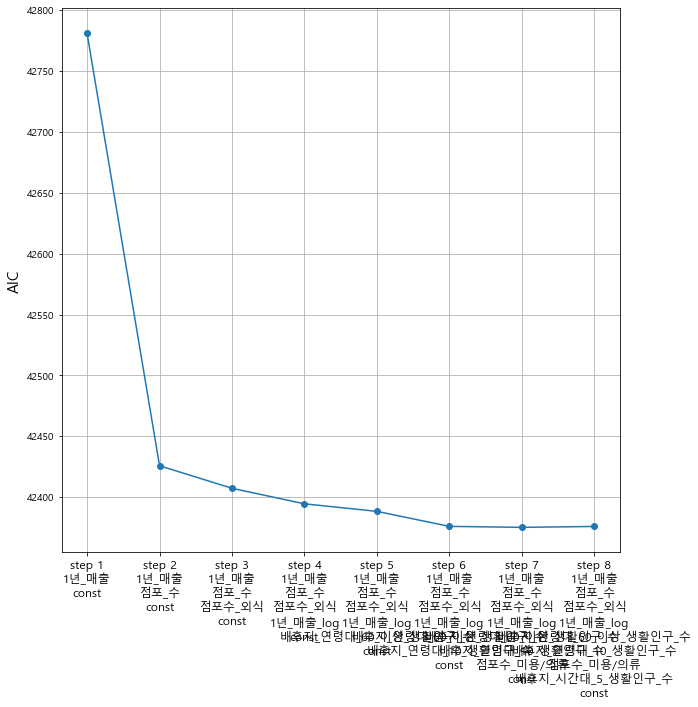

In [66]:
vis_AIC_step(s_model2)

In [74]:
s_model2["SUMMARY"][8]

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   coef   R-squared:                       0.455
Model:                            OLS   Adj. R-squared:                  0.451
Method:                 Least Squares   F-statistic:                     104.5
Date:                Mon, 11 Oct 2021   Prob (F-statistic):          2.18e-126
Time:                        17:14:58   Log-Likelihood:                -21179.
No. Observations:                1009   AIC:                         4.238e+04
Df Residuals:                    1000   BIC:                         4.242e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
1년_매출                    0.0217      0.001     24.409      0.000       0.020       0.023
점포_수                 -3.397e+06   3.43e+05     -9.912      0.000   -4.07e+06   -2.72e+06
점포수_외식               -2.621e+06   6.52e+05     -4.021      0.000    -3.9e+06   -1.34e+06
1년_매출_log            -7.358e+07   1.94e+07     -3.801      0.000   -1.12e+08   -3.56e+07
배후지_연령대_60_이상_생활인구_수   178.8283     46.139      3.876      0.000      88.289     269.368
배후지_연령대_10_생활인구_수     -152.7301     52.770     -2.894      0.004    -256.283     -49.177
점포수_미용/의류             1.497e+06   8.66e+05      1.728      0.084   -2.03e+05     3.2e+06
배후지_시간대_5_생활인구_수       -83.9036     74.840     -1.121      0.263    -230.764      62.957
const                  1.71e+09   4.31e+08      3.970      0.000    8.65e+08    2.56e+09
==============================================================================
Omnibus:                     1113.390   Durbin-Watson:                   1.920
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           281614.183
Skew:                          -4.840   Prob(JB):                         0.00
Kurtosis:                      84.270   Cond. No.                     1.25e+12
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.25e+12. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## target list

In [ ]:
df_t_total = pd.read_csv('data/j_result/매출_회귀계수.csv')
df_t_total = get_object_type(df_t_total)

df_t_total_log = pd.read_csv('data/j_result/매출_회귀계수_log.csv')
df_t_total_log = get_object_type(df_t_total_log)

df_t_food = pd.read_csv('data/j_result/음식_회귀계수.csv')
df_t_food = get_object_type(df_t_food)

df_t_weekend = pd.read_csv('data/j_result/주말_회귀계수.csv')
df_t_weekend = get_object_type(df_t_weekend)

# 피쳐 임포턴스 및 t-test 결과 분석

# 각 피쳐 5대 지표로 분류

# 5대 지표로 각각의 clustering

# 5대 지표를 통한 clustering